In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import random

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import RNN, SimpleRNN, LSTM, GRU, BatchNormalization, Dense
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

random.seed(2)
np.random.seed(2)
tf.random.set_seed(2)

2024-09-09 18:00:07.495842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 18:00:07.620245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-09 18:00:07.620276: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-09 18:00:07.655198: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 18:00:08.370338: W tensorflow/stream_executor/platform/de

In [ ]:
daily_gold = pd.read_csv("/work/Daily/Commodities/Daily_XAU_USD_01-12-2014_01-12-2024.csv")
daily_oil = pd.read_csv("/work/Daily/Commodities/Daily_Crude Oil_01-12-2014_01-12-2024.csv")

daily_barrick = pd.read_csv("/work/Daily/Stock/Daily_BARRICK_01-12-2014_01-12-2024.csv")
daily_newmont = pd.read_csv("/work/Daily/Stock/Daily_NEWMONT_01-12-2014_01-12-2024.csv")
daily_chevron = pd.read_csv("/work/Daily/Stock/Daily_CHEVRON_01-12-2014_01-12-2024.csv")
daily_exxon = pd.read_csv("/work/Daily/Stock/Daily_EXXON_01-12-2014_01-12-2024.csv")

weekly_gold = pd.read_csv("/work/Weekly/Commodities/Weekly_XAU_USD_01-12-2014_01-12-2024.csv")
weekly_oil = pd.read_csv("/work/Weekly/Commodities/Weekly_Crude Oil_01-12-2014_01-12-2024.csv")

weekly_barrick = pd.read_csv("/work/Weekly/Stock/Weekly_BARRICK_01-12-2014_01-12-2024.csv")
weekly_newmont = pd.read_csv("/work/Weekly/Stock/Weekly_NEWMONT_01-12-2014_01-12-2024.csv")
weekly_chevron = pd.read_csv("/work/Weekly/Stock/Weekly_CHEVRON_01-12-2014_01-12-2024.csv")
weekly_exxon = pd.read_csv("/work/Weekly/Stock/Weekly_EXXON_01-12-2014_01-12-2024.csv")

daily_gold = daily_gold.drop("Vol.", axis=1)
daily_oil = daily_oil.drop("Vol.", axis=1)

daily_barrick = daily_barrick.drop("Vol.", axis=1)
daily_newmont = daily_newmont.drop("Vol.", axis=1)
daily_chevron = daily_chevron.drop("Vol.", axis=1)
daily_exxon = daily_exxon.drop("Vol.", axis=1)

weekly_gold = weekly_gold.drop("Vol.", axis=1)
weekly_oil = weekly_oil.drop("Vol.", axis=1)

weekly_barrick = weekly_barrick.drop("Vol.", axis=1)
weekly_newmont = weekly_newmont.drop("Vol.", axis=1)
weekly_chevron = weekly_chevron.drop("Vol.", axis=1)
weekly_exxon = weekly_exxon.drop("Vol.", axis=1)

daily_gold.iloc[:, 1:] = daily_gold.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_oil.iloc[:, 1:] = daily_oil.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)

daily_barrick.iloc[:, 1:] = daily_barrick.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_newmont.iloc[:, 1:] = daily_newmont.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_chevron.iloc[:, 1:] = daily_chevron.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)
daily_exxon.iloc[:, 1:] = daily_exxon.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)

weekly_gold.iloc[:, 1:] = weekly_barrick.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_oil.iloc[:, 1:] = weekly_newmont.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)

weekly_barrick.iloc[:, 1:] = weekly_barrick.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_newmont.iloc[:, 1:] = weekly_newmont.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_chevron.iloc[:, 1:] = weekly_chevron.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)
weekly_exxon.iloc[:, 1:] = weekly_exxon.iloc[:, 1:].replace({',': '', '%': '', 'M':''}, regex=True).astype(float)

daily_gold.iloc[:, -1] *= 0.01
daily_oil.iloc[:, -1] *= 0.01
daily_barrick.iloc[:, -1] *= 0.01
daily_newmont.iloc[:, -1] *= 0.01
daily_chevron.iloc[:, -1] *= 0.01
daily_exxon.iloc[:, -1] *= 0.01

weekly_gold.iloc[:, -1] *= 0.01
weekly_oil.iloc[:, -1] *= 0.01
weekly_barrick.iloc[:, -1] *= 0.01
weekly_newmont.iloc[:, -1] *= 0.01
weekly_chevron.iloc[:, -1] *= 0.01
weekly_exxon.iloc[:, -1] *= 0.01

daily_gold['Date'] = pd.to_datetime(daily_gold['Date'], format='%m/%d/%Y', errors='coerce')
daily_oil['Date'] = pd.to_datetime(daily_oil['Date'], format='%m/%d/%Y', errors='coerce')

daily_barrick['Date'] = pd.to_datetime(daily_barrick['Date'], format='%m/%d/%Y', errors='coerce')
daily_newmont['Date'] = pd.to_datetime(daily_newmont['Date'], format='%m/%d/%Y', errors='coerce')
daily_chevron['Date'] = pd.to_datetime(daily_chevron['Date'], format='%m/%d/%Y', errors='coerce')
daily_exxon['Date'] = pd.to_datetime(daily_exxon['Date'], format='%m/%d/%Y', errors='coerce')

weekly_gold['Date'] = pd.to_datetime(weekly_gold['Date'], format='%m/%d/%Y', errors='coerce')
weekly_oil['Date'] = pd.to_datetime(weekly_oil['Date'], format='%m/%d/%Y', errors='coerce')

weekly_barrick['Date'] = pd.to_datetime(weekly_barrick['Date'], format='%m/%d/%Y', errors='coerce')
weekly_newmont['Date'] = pd.to_datetime(weekly_newmont['Date'], format='%m/%d/%Y', errors='coerce')
weekly_chevron['Date'] = pd.to_datetime(weekly_chevron['Date'], format='%m/%d/%Y', errors='coerce')
weekly_exxon['Date'] = pd.to_datetime(weekly_exxon['Date'], format='%m/%d/%Y', errors='coerce')

daily_gold.set_index('Date', inplace=True)
daily_oil.set_index('Date', inplace=True)

daily_barrick.set_index('Date', inplace=True)
daily_newmont.set_index('Date', inplace=True)
daily_chevron.set_index('Date', inplace=True)
daily_exxon.set_index('Date', inplace=True)

weekly_gold.set_index('Date', inplace=True)
weekly_oil.set_index('Date', inplace=True)

weekly_barrick.set_index('Date', inplace=True)
weekly_newmont.set_index('Date', inplace=True)
weekly_chevron.set_index('Date', inplace=True)
weekly_exxon.set_index('Date', inplace=True)

In [ ]:
master_daily = daily_gold.add_suffix('_gold')

dfs = [daily_oil, daily_barrick, daily_newmont, daily_exxon, daily_chevron]

suffixes = ['_oil', '_barrick', '_newmont', '_exxon', '_chevron']

suffix_dfs = []

for i in range(len(dfs)):
    suffix_dfs.append(dfs[i].add_suffix(suffixes[i]))

for i in range(len(dfs)):
    master_daily = master_daily.join(suffix_dfs[i])

master_daily = master_daily.dropna()

master_daily

Price_gold Open_gold High_gold Low_gold Change %_gold  Price_oil  \
Date                                                                          
2024-01-11    2028.09   2023.74   2039.69  2013.32        0.0023      72.02   
2024-01-10     2023.4   2029.94   2040.44  2020.45       -0.0031      71.37   
2024-01-09    2029.59    2028.4   2042.09  2026.11        0.0009      72.24   
2024-01-08    2027.84   2044.08   2046.71  2016.84       -0.0086      70.77   
2024-01-05     2045.5   2043.69   2064.03  2024.49        0.0011      73.81   
...               ...       ...       ...      ...           ...        ...   
2014-01-17    1253.82   1242.53   1255.28  1238.05        0.0091      94.37   
2014-01-16    1242.55   1241.49   1245.26  1236.55        0.0007      93.96   
2014-01-15    1241.74    1245.1   1245.39  1234.49       -0.0027      94.17   
2014-01-14     1245.1   1253.12   1255.38  1241.83       -0.0067      92.59   
2014-01-13    1253.44   1248.28   1255.18  1243.72        0.0051      91.80   

            Open_oil  High_oil  Low_oil Change %_oil  ...  Price_exxon  \
Date                                                  ...                
2024-01-11     71.33     73.81    71.17       0.0091  ...        98.67   
2024-01-10     72.17     73.59    71.01       -0.012  ...        98.69   
2024-01-09     70.91     72.93    70.47       0.0208  ...        99.67   
2024-01-08     73.51     73.95    70.13      -0.0412  ...       100.92   
2024-01-05     72.40     74.24    72.21       0.0224  ...       102.63   
...              ...       ...      ...          ...  ...          ...   
2014-01-17     94.17     94.94    93.94       0.0044  ...        99.16   
2014-01-16     94.29     94.64    93.60      -0.0022  ...        98.94   
2014-01-15     92.65     94.64    92.43       0.0171  ...        98.78   
2014-01-14     91.51     92.88    91.50       0.0086  ...        99.12   
2014-01-13     92.83     92.88    91.43      -0.0099  ...        98.55   

            Open_exxon  High_exxon  Low_exxon Change %_exxon  Price_chevron  \
Date                                                                          
2024-01-11       99.04       99.50      98.56        -0.0002         145.28   
2024-01-10       99.80       99.80      98.16        -0.0098         144.50   
2024-01-09      101.29      101.29      99.19        -0.0124         145.70   
2024-01-08      100.73      101.04      98.90        -0.0167         149.50   
2024-01-05      103.17      103.40     102.13          0.003         150.40   
...                ...         ...        ...            ...            ...   
2014-01-17       99.18      100.34      98.67         0.0022         119.29   
2014-01-16       98.79       99.04      98.25         0.0016         118.83   
2014-01-15       99.16       99.35      98.63        -0.0034         119.18   
2014-01-14       98.80       99.27      98.65         0.0058         119.57   
2014-01-13       99.91      100.10      98.27        -0.0196         119.25   

            Open_chevron  High_chevron  Low_chevron Change %_chevron  
Date                                                                  
2024-01-11        145.56        146.17       144.62           0.0054  
2024-01-10        146.02        146.02       144.11          -0.0082  
2024-01-09        149.95        149.95       145.59          -0.0254  
2024-01-08        148.42        149.70       146.58           -0.006  
2024-01-05        151.98        152.03       149.83          -0.0017  
...                  ...           ...          ...              ...  
2014-01-17        119.03        120.38       118.74           0.0039  
2014-01-16        119.11        119.29       118.19          -0.0029  
2014-01-15        119.69        120.07       119.05          -0.0033  
2014-01-14        119.40        119.75       118.80           0.0027  
2014-01-13        120.81        120.90       119.01          -0.0145  

[2517 rows x 30 columns]

### EDA

#### Gold & Stocks Related

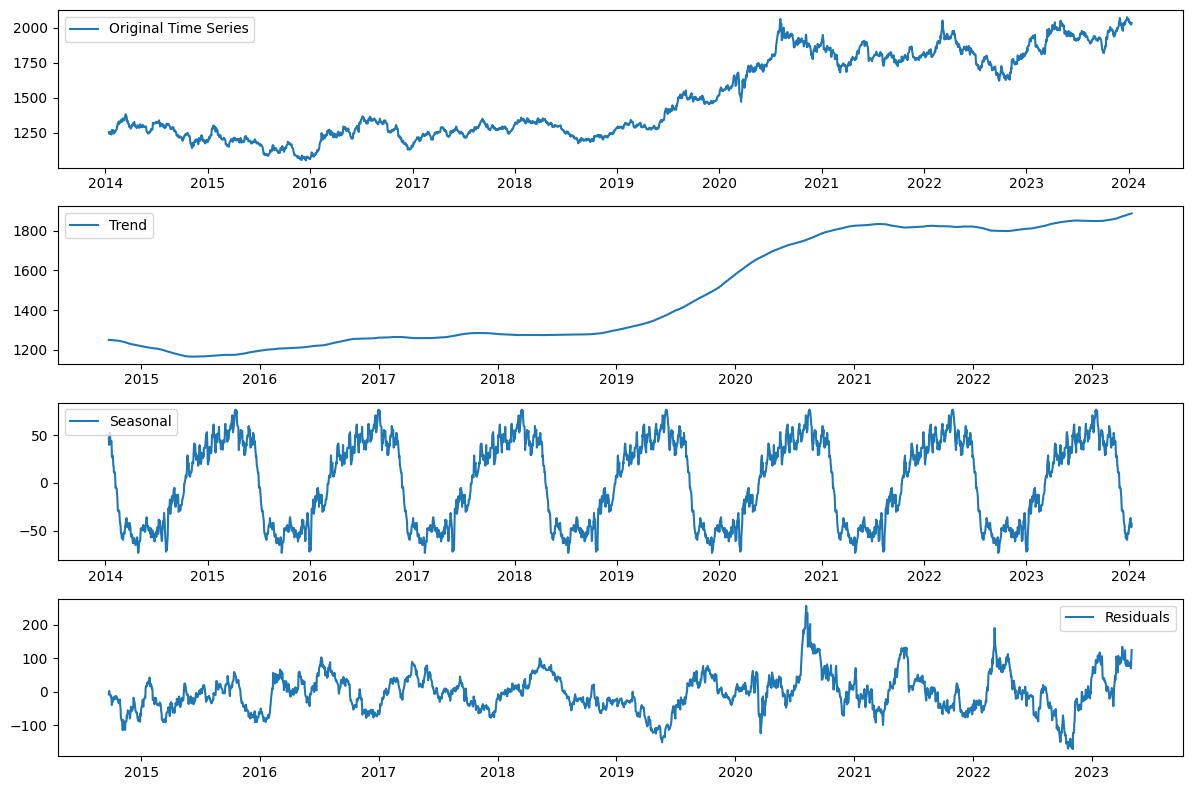

In [ ]:
#Gold

result_daily_gold = seasonal_decompose(daily_gold['Price'], model='additive', period=365)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(daily_gold.index, daily_gold['Price'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(daily_gold.index, result_daily_gold.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(daily_gold.index, result_daily_gold.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(daily_gold.index, result_daily_gold.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

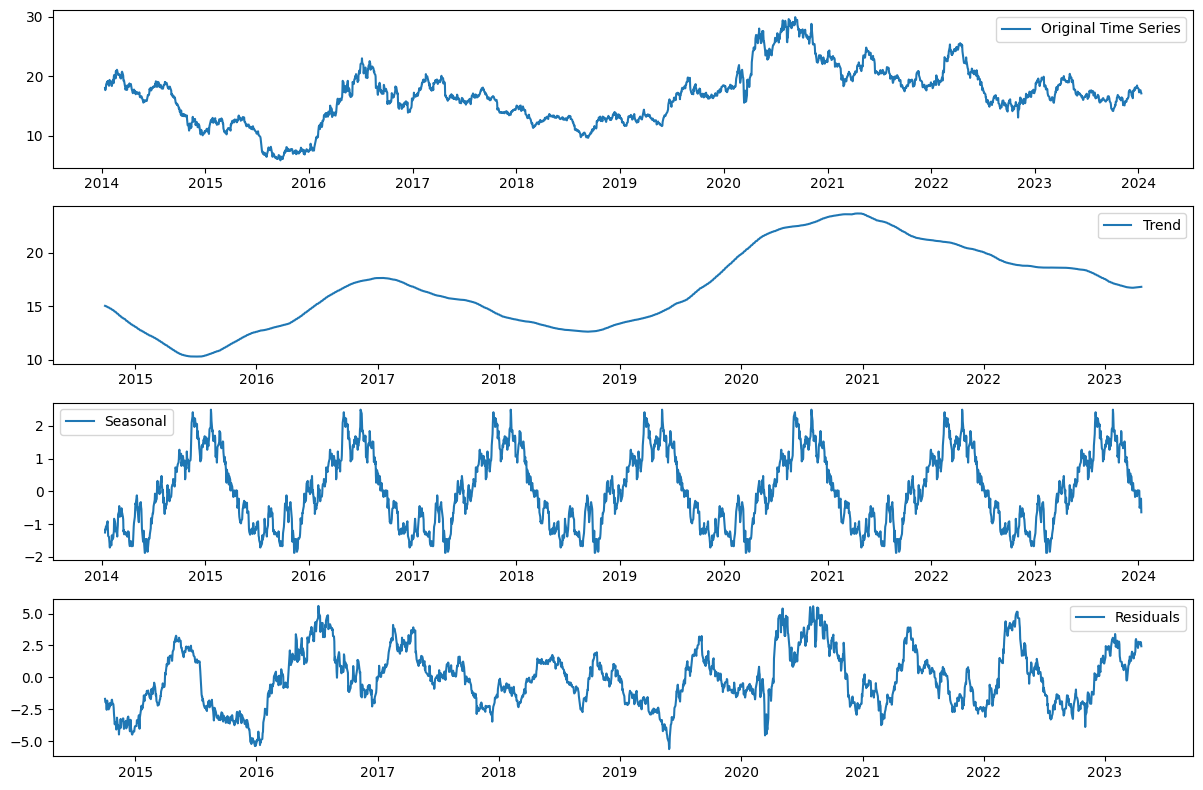

In [ ]:
#Barrick

result_daily_barrick = seasonal_decompose(daily_barrick['Price'], model='additive', period=365)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(daily_barrick.index, daily_barrick['Price'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(daily_barrick.index, result_daily_barrick.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(daily_barrick.index, result_daily_barrick.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(daily_barrick.index, result_daily_barrick.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

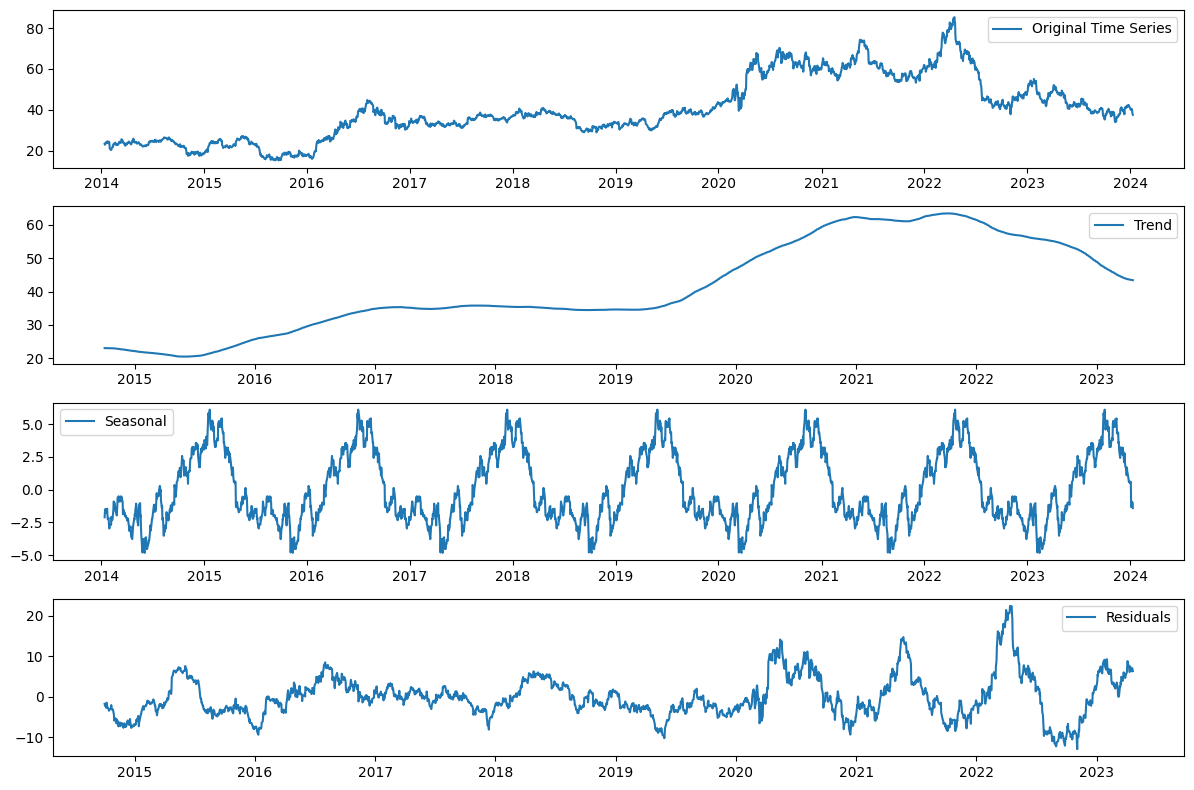

In [ ]:
result_daily_newmont = seasonal_decompose(daily_newmont['Price'], model='additive', period=365)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(daily_newmont.index, daily_newmont['Price'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(daily_newmont.index, result_daily_newmont.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(daily_newmont.index, result_daily_newmont.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(daily_newmont.index, result_daily_newmont.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

#### Oil & Related Stocks

Trend untuk harga saham chevron dan exxon mengikuti trend harga minyak sejak 2016. Namun, khususnya untuk harga saham exxon, sebelum tahun 2016 trendnya tidak mirip dengan trend harga minyak. Sselain itu, secara visual,  seasonality dari harga saham exxon sangat mirip dengan harga sama chevron.

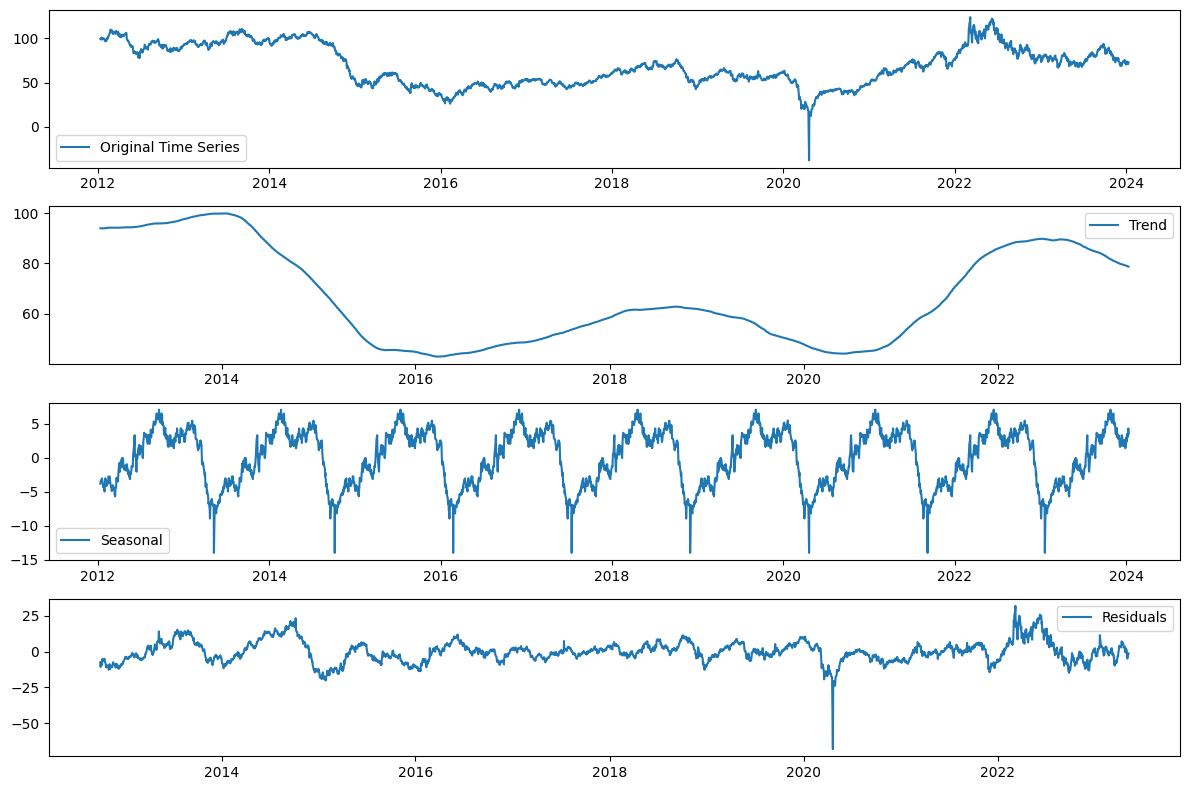

In [ ]:
result_daily_oil = seasonal_decompose(daily_oil['Price'], model='additive', period=365)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(daily_oil.index, daily_oil['Price'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(daily_oil.index, result_daily_oil.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(daily_oil.index, result_daily_oil.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(daily_oil.index, result_daily_oil.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

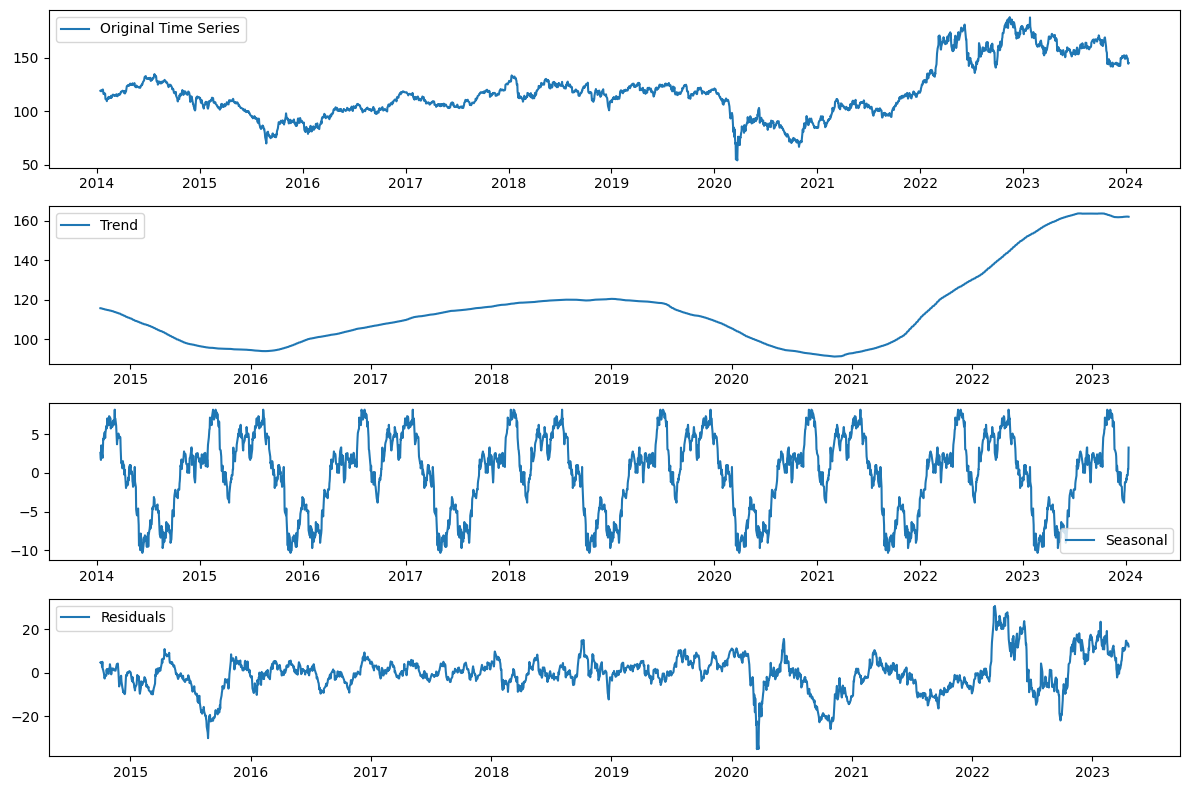

In [ ]:
result_daily_chevron = seasonal_decompose(daily_chevron['Price'], model='additive', period=365)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(daily_chevron.index, daily_chevron['Price'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(daily_chevron.index, result_daily_chevron.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(daily_chevron.index, result_daily_chevron.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(daily_chevron.index, result_daily_chevron.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

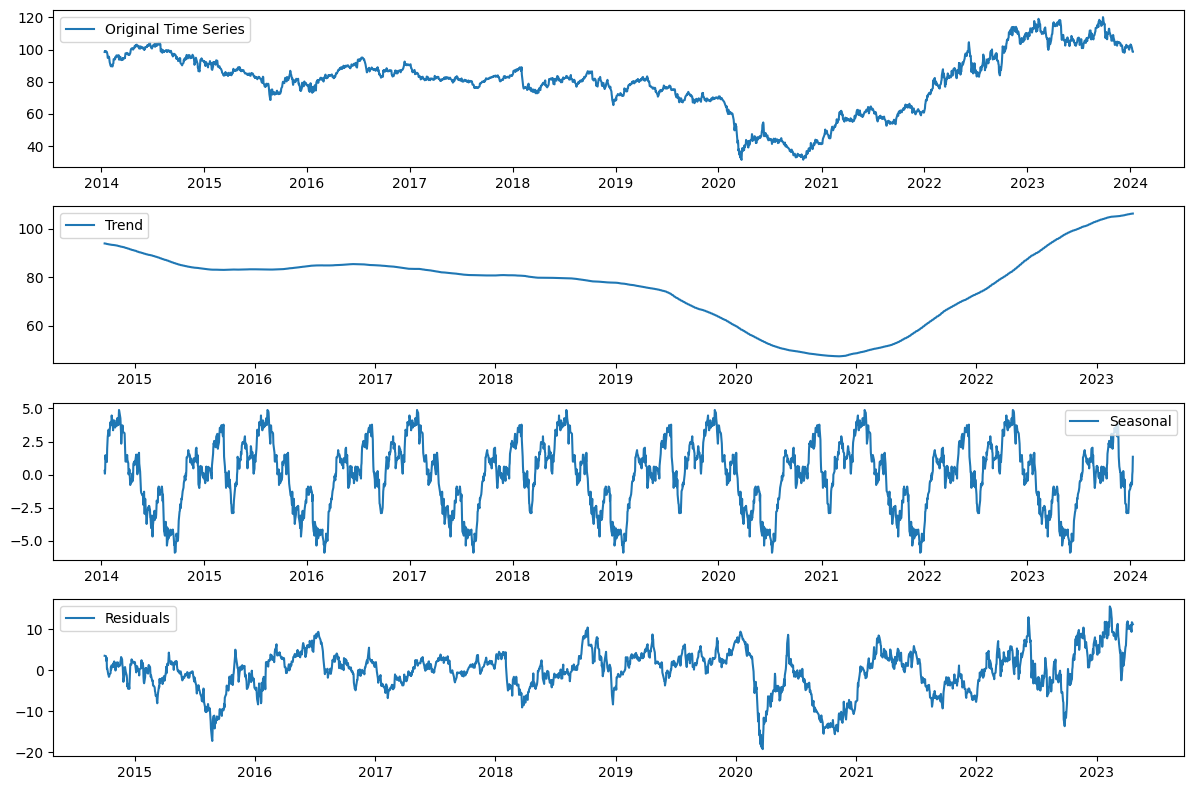

In [ ]:
result_daily_exxon = seasonal_decompose(daily_exxon['Price'], model='additive', period=365)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(daily_exxon.index, daily_exxon['Price'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(daily_exxon.index, result_daily_exxon.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(daily_exxon.index, result_daily_exxon.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(daily_exxon.index, result_daily_exxon.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

### Autocorrelation

In [ ]:
autocorr_dailybarrick = pd.DataFrame()
autocorr_dailybarrick["Price"] = daily_barrick["Price"]
autocorr_dailybarrick["Price_Lag_1"] = autocorr_dailybarrick["Price"].shift(1)
autocorr_dailybarrick["Price_Lag_2"] = autocorr_dailybarrick["Price"].shift(2)
autocorr_dailybarrick["Price_Lag_3"] = autocorr_dailybarrick["Price"].shift(3)

In [ ]:
mean_nolag = autocorr_dailybarrick["Price"].mean()
# Sum of Squared Deviations
ssd_nolag = ((autocorr_dailybarrick["Price"] - mean_nolag) ** 2).sum()
autocorr_dailybarrick["wadits"] = autocorr_dailybarrick["Price_Lag_3"] - mean_nolag
autocorr = (autocorr_dailybarrick['Price'] * autocorr_dailybarrick['wadits']).sum() / ssd_nolag
autocorr

0.9866671797654983

In [ ]:
acorr = sm.tsa.acf(autocorr_dailybarrick["Price"], nlags = 5)
acorr

array([1.        , 0.99587858, 0.99175007, 0.98776114, 0.98360519,
       0.97943065])

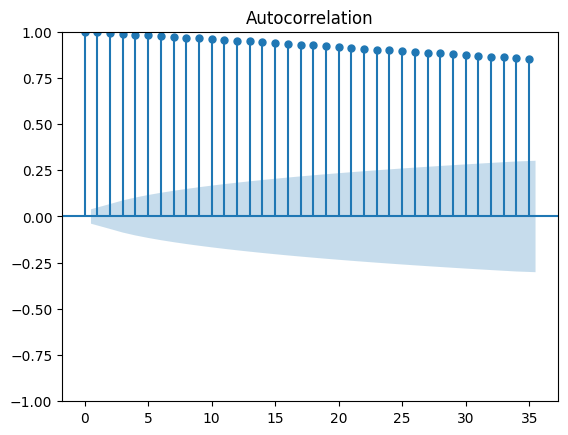

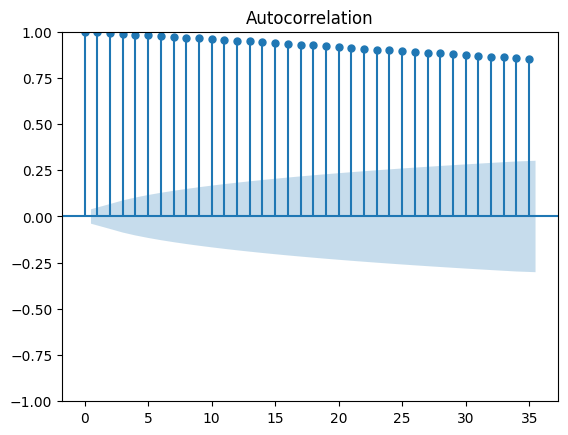

In [ ]:
plot_acf(autocorr_dailybarrick["Price"])

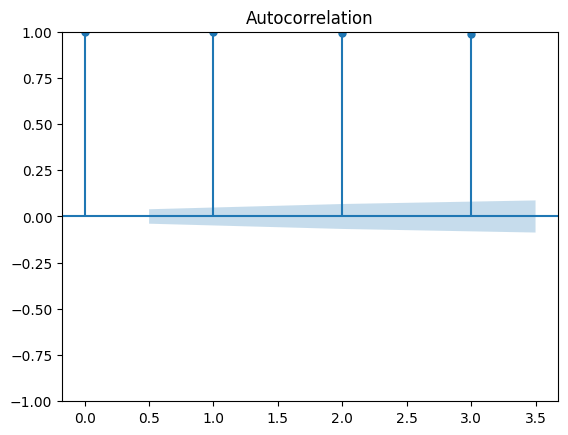

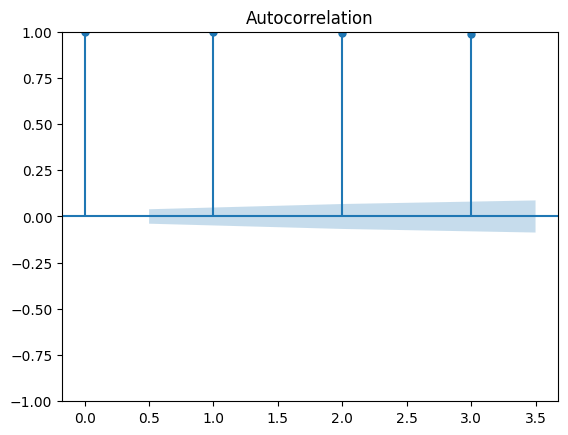

In [ ]:
plot_acf(autocorr_dailybarrick["Price"], lags = 3)

##### 0.98 AUTOCORRELATION IS VERY STRONG RELATIONSHIP 

### Cross Correlation

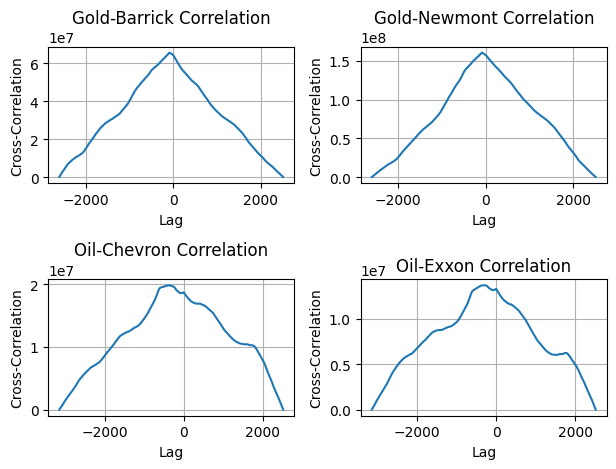

In [ ]:
from scipy.signal import correlate

# Compute correlations
gold_barrick_correlation = correlate(daily_gold['Price'], daily_barrick['Price'], mode='full')
gold_newmont_correlation = correlate(daily_gold['Price'], daily_newmont['Price'], mode='full')
oil_chevron_correlation = correlate(daily_oil['Price'], daily_chevron['Price'], mode='full')
oil_exxon_correlation = correlate(daily_oil['Price'], daily_exxon['Price'], mode='full')

# Compute lags
lags_gold_barrick = np.arange(-len(daily_gold['Price']) + 1, len(daily_barrick['Price']))
lags_gold_newmont = np.arange(-len(daily_gold['Price']) + 1, len(daily_newmont['Price']))
lags_oil_chevron = np.arange(-len(daily_oil['Price']) + 1, len(daily_chevron['Price']))
lags_oil_exxon = np.arange(-len(daily_oil['Price']) + 1, len(daily_exxon['Price']))

# Create subplots
fig, axs = plt.subplots(2, 2)

# Plot each correlation on its respective subplot
axs[0, 0].plot(lags_gold_barrick, gold_barrick_correlation)
axs[0, 0].set_title('Gold-Barrick Correlation')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('Cross-Correlation')
axs[0, 0].grid(True)

axs[0, 1].plot(lags_gold_newmont, gold_newmont_correlation)
axs[0, 1].set_title('Gold-Newmont Correlation')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('Cross-Correlation')
axs[0, 1].grid(True)

axs[1, 0].plot(lags_oil_chevron, oil_chevron_correlation)
axs[1, 0].set_title('Oil-Chevron Correlation')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('Cross-Correlation')
axs[1, 0].grid(True)

axs[1, 1].plot(lags_oil_exxon, oil_exxon_correlation)
axs[1, 1].set_title('Oil-Exxon Correlation')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('Cross-Correlation')
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

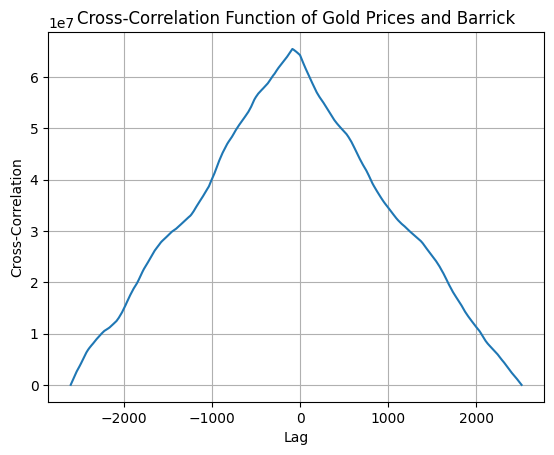

In [ ]:
from scipy.signal import correlate

gold_barrick_correlation = correlate(daily_gold['Price'], daily_barrick['Price'], mode='full')

lags_gold_barrick = np.arange(-len(daily_gold['Price']) + 1, len(daily_barrick['Price']))
plt.plot(lags_gold_barrick, gold_barrick_correlation)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Function of Gold Prices and Barrick')
plt.grid(True)
plt.show()

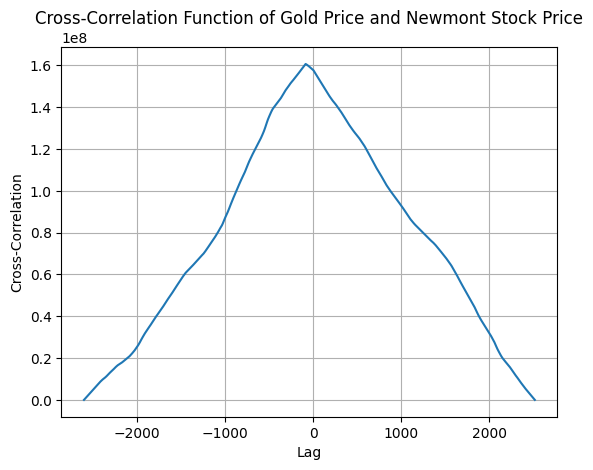

In [ ]:
gold_newmont_correlation = correlate(daily_gold['Price'], daily_newmont['Price'], mode='full')

lags_gold_newmont = np.arange(-len(daily_gold['Price']) + 1, len(daily_newmont['Price']))
plt.plot(lags_gold_newmont, gold_newmont_correlation)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Function of Gold Price and Newmont Stock Price')
plt.grid(True)
plt.show()

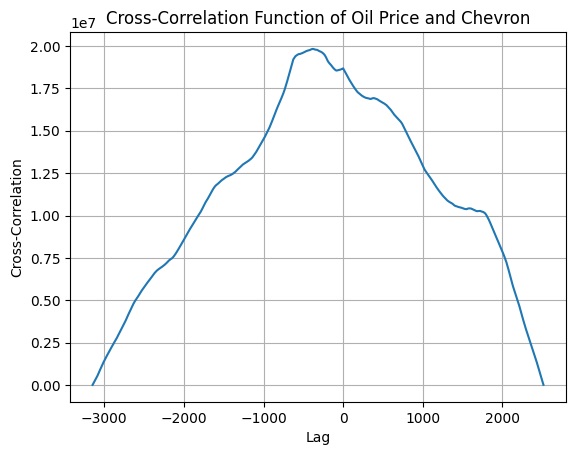

In [ ]:
oil_chevron_correlation = correlate(daily_oil['Price'], daily_chevron['Price'], mode='full')

lags_oil_chevron = np.arange(-len(daily_oil['Price']) + 1, len(daily_chevron['Price']))
plt.plot(lags_oil_chevron, oil_chevron_correlation)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Function of Oil Price and Chevron')
plt.grid(True)
plt.show()

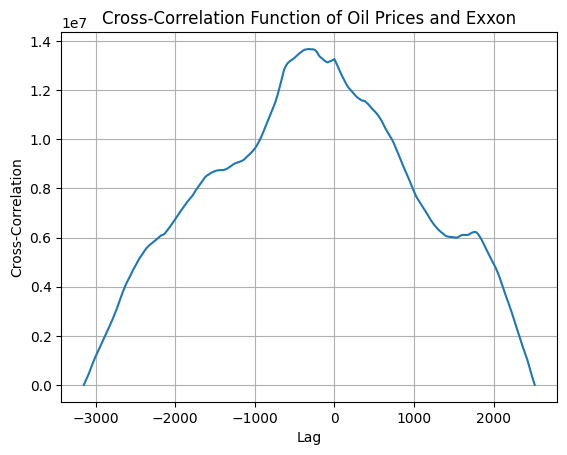

In [ ]:
oil_exxon_correlation = correlate(daily_oil['Price'], daily_exxon['Price'], mode='full')

lags_oil_exxon = np.arange(-len(daily_oil['Price']) + 1, len(daily_exxon['Price']))
plt.plot(lags_oil_exxon, oil_exxon_correlation)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Function of Oil Prices and Exxon')
plt.grid(True)
plt.show()

### Seasonality

In [ ]:
daily_barrick

Price   Open   High    Low Change %
Date                                           
2024-01-11  17.15  17.38  17.49  16.94   -0.011
2024-01-10  17.34  17.44  17.52  17.20  -0.0034
2024-01-09  17.40  17.69  17.70  17.37  -0.0164
2024-01-08  17.69  17.39  17.92  17.31   0.0114
2024-01-05  17.49  17.44  17.72  17.26   0.0081
...           ...    ...    ...    ...      ...
2014-01-17  18.66  18.34  18.79  18.34   0.0304
2014-01-16  18.11  18.09  18.20  17.85   0.0095
2014-01-15  17.94  17.54  18.03  17.48   0.0136
2014-01-14  17.70  17.99  18.16  17.59  -0.0205
2014-01-13  18.07  18.03  18.10  17.59  -0.0006

[2517 rows x 5 columns]

### Time-Series Aggregation

In [ ]:
daily_gold_gren = pd.read_csv("/work/Daily/Commodities/Daily_XAU_USD_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_gold_gren2 = pd.read_csv("/work/Daily/Commodities/Daily_XAU_USD_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_oil_gren = pd.read_csv("/work/Daily/Commodities/Daily_XBR_USD_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_oil_gren2 = pd.read_csv("/work/Daily/Commodities/Daily_XBR_USD_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_barrick_gren = pd.read_csv("/work/Daily/Stock/Daily_BARRICK_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_barrick_gren2 = pd.read_csv("/work/Daily/Stock/Daily_BARRICK_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_newmont_gren = pd.read_csv("/work/Daily/Stock/Daily_NEWMONT_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_newmont_gren2 = pd.read_csv("/work/Daily/Stock/Daily_NEWMONT_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_chevron_gren = pd.read_csv("/work/Daily/Stock/Daily_CHEVRON_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_chevron_gren2 = pd.read_csv("/work/Daily/Stock/Daily_CHEVRON_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_exxon_gren = pd.read_csv("/work/Daily/Stock/Daily_EXXON_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)
daily_exxon_gren2 = pd.read_csv("/work/Daily/Stock/Daily_EXXON_01-12-2014_01-12-2024.csv").drop(["Vol.", "Open", "High", "Low", "Change %"], axis = 1)

In [ ]:
daily_gold_gren['Date'] = pd.to_datetime(daily_gold_gren['Date'])
daily_gold_gren2['Date'] = pd.to_datetime(daily_gold_gren2['Date'])
daily_gold_gren.set_index('Date', inplace=True)
daily_gold_gren2.set_index('Date', inplace=True)

daily_oil_gren['Date'] = pd.to_datetime(daily_oil_gren['Date'])
daily_oil_gren2['Date'] = pd.to_datetime(daily_oil_gren2['Date'])
daily_oil_gren.set_index('Date', inplace=True)
daily_oil_gren2.set_index('Date', inplace=True)

daily_gold_gren['Price'] = pd.to_numeric(daily_gold_gren['Price'].str.replace(',', ''), errors ='coerce')
daily_gold_gren2['Price'] = pd.to_numeric(daily_gold_gren2['Price'].str.replace(',', ''), errors='coerce')
if daily_oil_gren['Price'].dtype == 'O':
    daily_oil_gren['Price'] = pd.to_numeric(daily_oil_gren['Price'].str.replace(',', ''), errors='coerce')
if daily_oil_gren2['Price'].dtype == 'O':
    daily_oil_gren2['Price'] = pd.to_numeric(daily_oil_gren2['Price'].str.replace(',', ''), errors='coerce')

weekly_gold_gren = daily_gold_gren['Price'].resample('W').mean().to_frame(name='Price')
monthly_gold_gren = daily_gold_gren2['Price'].resample('M').mean().to_frame(name='Price')
weekly_oil_gren = daily_oil_gren['Price'].resample('W').mean().to_frame(name='Price')
monthly_oil_gren = daily_oil_gren2['Price'].resample('M').mean().to_frame(name='Price')

In [ ]:
daily_barrick_gren['Date'] = pd.to_datetime(daily_barrick_gren['Date'])
daily_barrick_gren2['Date'] = pd.to_datetime(daily_barrick_gren2['Date'])
daily_barrick_gren.set_index('Date', inplace=True)
daily_barrick_gren2.set_index('Date', inplace=True)

daily_newmont_gren['Date'] = pd.to_datetime(daily_newmont_gren['Date'])
daily_newmont_gren2['Date'] = pd.to_datetime(daily_newmont_gren2['Date'])
daily_newmont_gren.set_index('Date', inplace=True)
daily_newmont_gren2.set_index('Date', inplace=True)

daily_chevron_gren['Date'] = pd.to_datetime(daily_chevron_gren['Date'])
daily_chevron_gren2['Date'] = pd.to_datetime(daily_chevron_gren2['Date'])
daily_chevron_gren.set_index('Date', inplace=True)
daily_chevron_gren2.set_index('Date', inplace=True)

daily_exxon_gren['Date'] = pd.to_datetime(daily_exxon_gren['Date'])
daily_exxon_gren2['Date'] = pd.to_datetime(daily_exxon_gren2['Date'])
daily_exxon_gren.set_index('Date', inplace=True)
daily_exxon_gren2.set_index('Date', inplace=True)

daily_barrick_gren['Price'] = pd.to_numeric(daily_barrick_gren['Price'])
daily_barrick_gren2['Price'] = pd.to_numeric(daily_barrick_gren2['Price'])
daily_newmont_gren['Price'] = pd.to_numeric(daily_newmont_gren['Price'])
daily_newmont_gren2['Price'] = pd.to_numeric(daily_newmont_gren2['Price'])
daily_chevron_gren['Price'] = pd.to_numeric(daily_chevron_gren['Price'])
daily_chevron_gren2['Price'] = pd.to_numeric(daily_chevron_gren2['Price'])
daily_exxon_gren['Price'] = pd.to_numeric(daily_exxon_gren['Price'])
daily_exxon_gren2['Price'] = pd.to_numeric(daily_exxon_gren2['Price'])

weekly_barrick_gren = daily_barrick_gren['Price'].resample('W').mean().to_frame(name='Price')
monthly_barrick_gren = daily_barrick_gren2['Price'].resample('M').mean().to_frame(name='Price')
weekly_newmont_gren = daily_newmont_gren['Price'].resample('W').mean().to_frame(name='Price')
monthly_newmont_gren = daily_newmont_gren2['Price'].resample('M').mean().to_frame(name='Price')
weekly_chevron_gren = daily_chevron_gren['Price'].resample('W').mean().to_frame(name='Price')
monthly_chevron_gren = daily_chevron_gren2['Price'].resample('M').mean().to_frame(name='Price')
weekly_exxon_gren = daily_exxon_gren['Price'].resample('W').mean().to_frame(name='Price')
monthly_exxon_gren = daily_exxon_gren2['Price'].resample('M').mean().to_frame(name='Price')

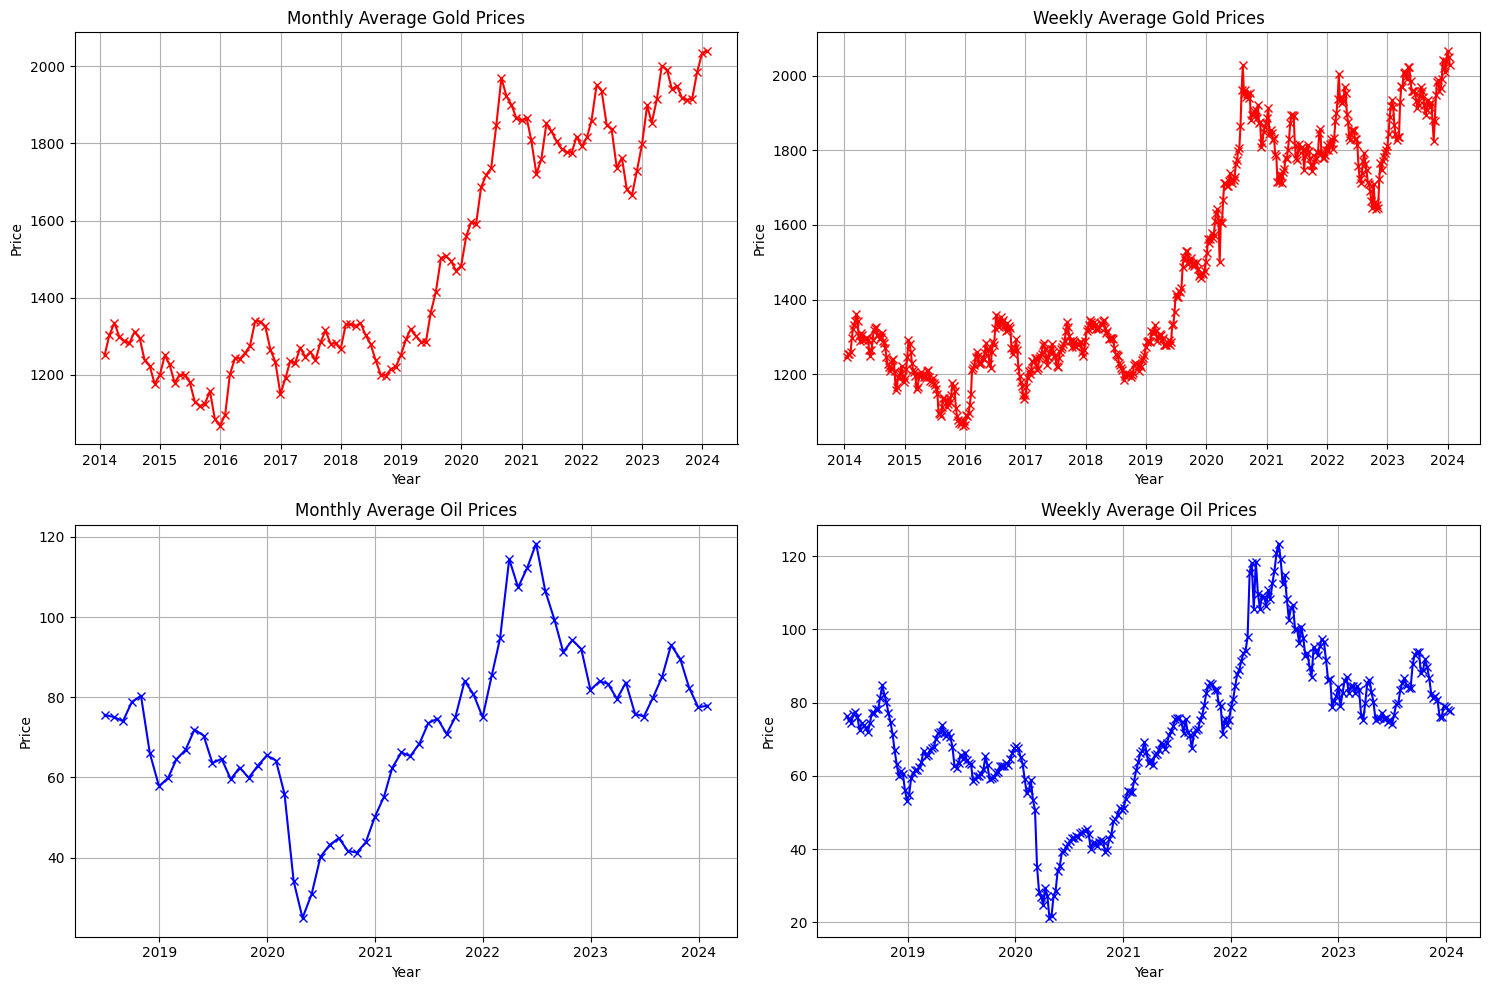

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(monthly_gold_gren.index, monthly_gold_gren['Price'], marker='x', linestyle='solid', color='r')
plt.title('Monthly Average Gold Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(weekly_gold_gren.index, weekly_gold_gren['Price'], marker='x', linestyle='solid', color='r')
plt.title('Weekly Average Gold Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(monthly_oil_gren.index, monthly_oil_gren['Price'], marker='x', linestyle='solid', color='b')
plt.title('Monthly Average Oil Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(weekly_oil_gren.index, weekly_oil_gren['Price'], marker='x', linestyle='solid', color='b')
plt.title('Weekly Average Oil Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.tight_layout()
plt.show()

- Gold prices are slightly more stable than oil prices. The graphs (especially monthly) shows that gold prices have a smoother trend and less volatility than oil prices. Another way to interpret this is that gold prices are less likely to be affected by external factors.
- Gold prices are currently increasing by a significant amount since 2018, while oil prices have their peak recently at around 2022, they are currently decreasing.

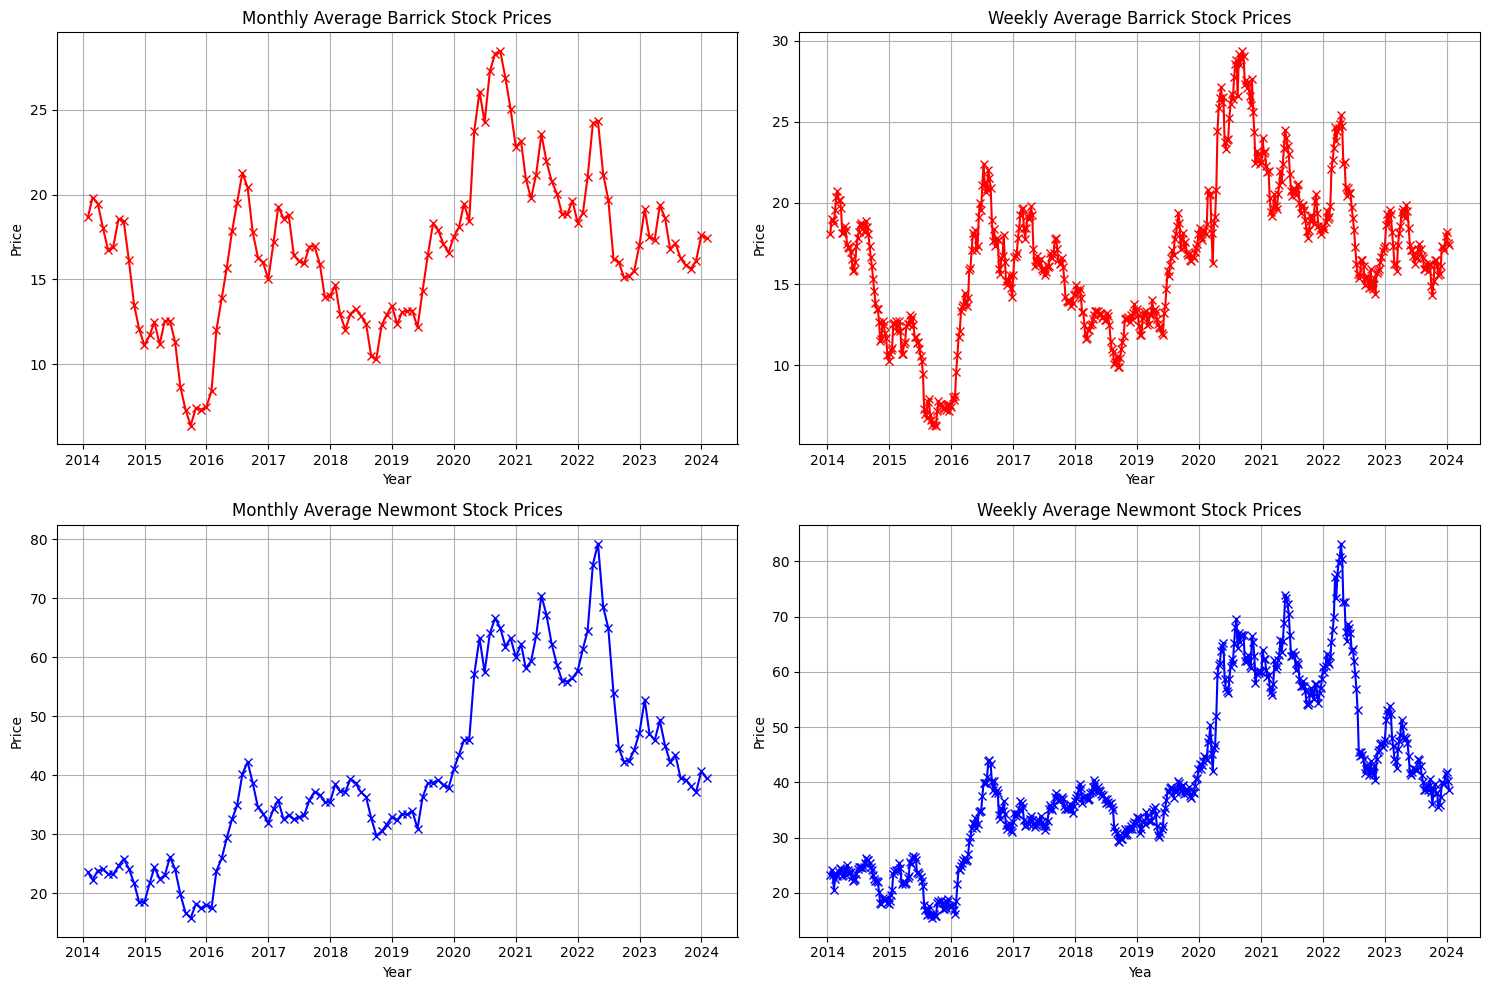

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(monthly_barrick_gren.index, monthly_barrick_gren['Price'], marker='x', linestyle='solid', color='r')
plt.title('Monthly Average Barrick Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(weekly_barrick_gren.index, weekly_barrick_gren['Price'], marker='x', linestyle='solid', color='r')
plt.title('Weekly Average Barrick Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(monthly_newmont_gren.index, monthly_newmont_gren['Price'], marker='x', linestyle='solid', color='b')
plt.title('Monthly Average Newmont Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(weekly_newmont_gren.index, weekly_newmont_gren['Price'], marker='x', linestyle='solid', color='b')
plt.title('Weekly Average Newmont Stock Prices')
plt.xlabel('Yea')
plt.ylabel('Price')
plt.grid(True)

plt.tight_layout()
plt.show()

The graphs indicate that both company stock prices have experienced fluctuations over the years, with some periods of growth and decline. These two stock prices tend to move in the same direction, suggesting that they are both influenced by the same factors (example: gold prices, production costs, industry competition)

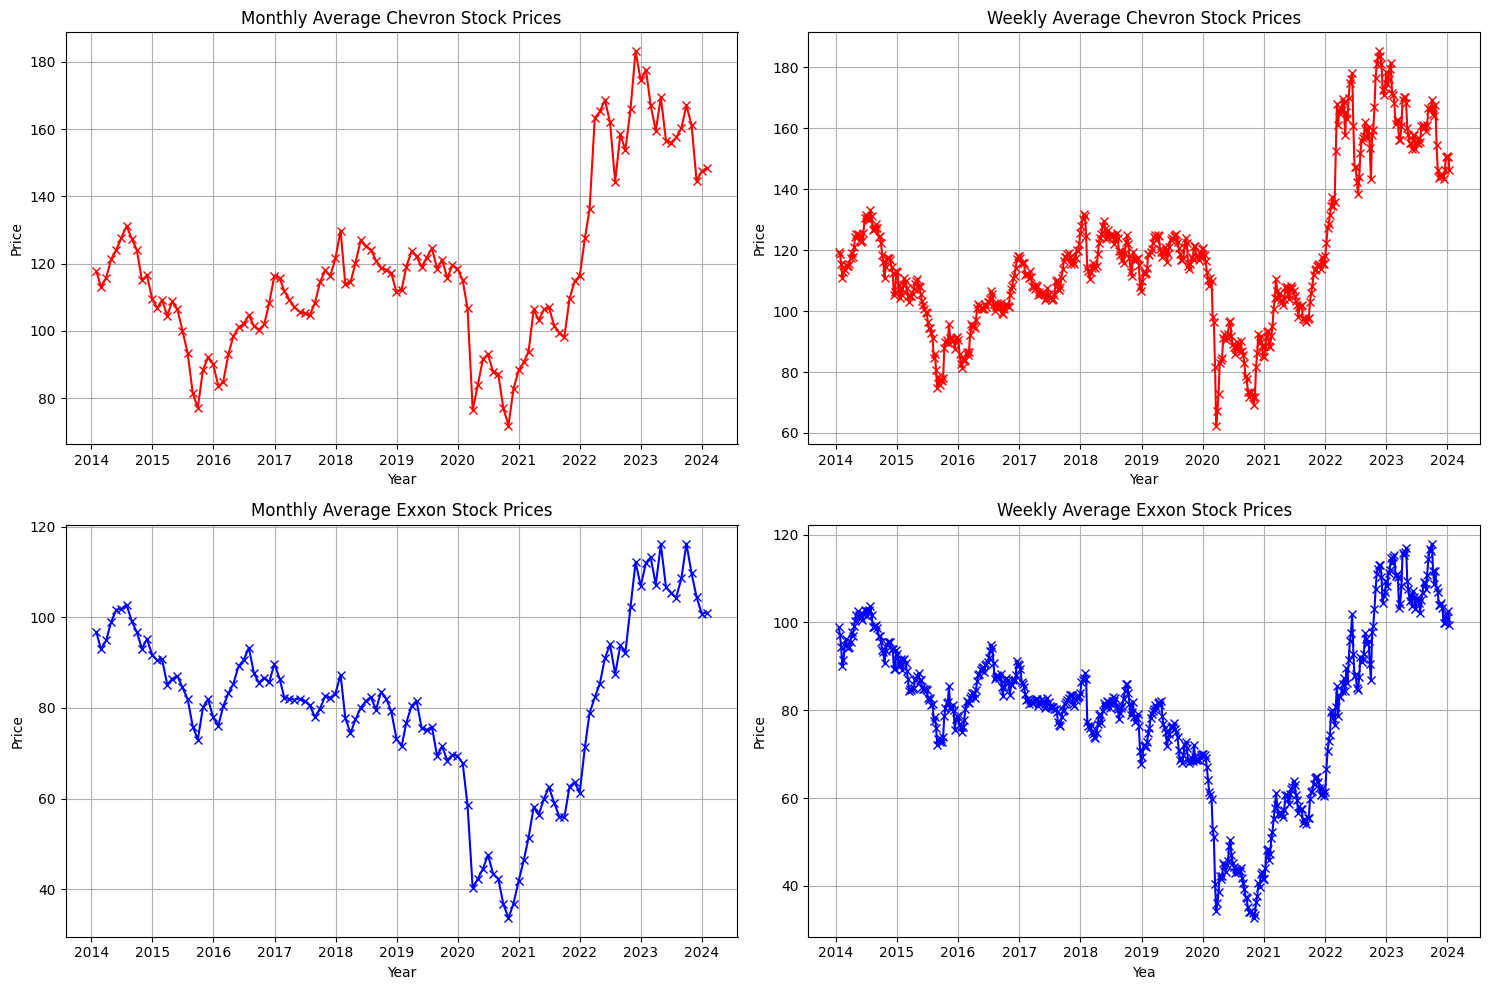

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(monthly_chevron_gren.index, monthly_chevron_gren['Price'], marker='x', linestyle='solid', color='r')
plt.title('Monthly Average Chevron Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(weekly_chevron_gren.index, weekly_chevron_gren['Price'], marker='x', linestyle='solid', color='r')
plt.title('Weekly Average Chevron Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(monthly_exxon_gren.index, monthly_exxon_gren['Price'], marker='x', linestyle='solid', color='b')
plt.title('Monthly Average Exxon Stock Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(weekly_exxon_gren.index, weekly_exxon_gren['Price'], marker='x', linestyle='solid', color='b')
plt.title('Weekly Average Exxon Stock Prices')
plt.xlabel('Yea')
plt.ylabel('Price')
plt.grid(True)

plt.tight_layout()
plt.show()

The fluctuations in stock prices of these oil-producing companies share a really strong resemblance. During each period of time, the trend is closely related. Whether the price is peaking or bottoming out.

### RNN

#### Gold

In [ ]:
#Gold

# Define your features (dependent variables) and target (independent variable)
features = ['Open', 'High', 'Low', 'Change %']
target = 'Price'

# Normalize the data
scaler = MinMaxScaler()
daily_gold_scaled = pd.DataFrame()
daily_gold_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_gold[['Open', 'High', 'Low', 'Change %','Price']])
daily_gold_time = daily_gold.index
daily_gold_scaled.set_index(daily_gold_time,inplace = True)
daily_gold_scaled = daily_gold_scaled[::-1]

# Define the window size for the RNN
window_size = 5

# Function to create input data sequences and labels
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[features][i:i+window_size].values)
        y.append([data[target][i+window_size]])
    return np.array(X), np.array(y)

# Create sequences and labels
X_gold, y_gold = create_sequences(daily_gold_scaled, window_size)

y_gold = pd.DataFrame(y_gold).set_index(daily_gold_scaled.index[window_size:len(daily_gold_scaled)])

# Split the data into training and testing sets
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(X_gold, y_gold, test_size=0.2, shuffle=False)

# Define the model
model_RNN_Gold = Sequential([
    SimpleRNN(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    SimpleRNN(64, activation = 'relu', return_sequences=True),
    SimpleRNN(32, activation = 'relu', return_sequences=True),
    SimpleRNN(16, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_RNN_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_RNN_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_RNN_Gold_train = model_RNN_Gold.evaluate(X_train_gold, y_train_gold)
loss_RNN_Gold_test = model_RNN_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_RNN_Gold_train)
print("Test Loss:", loss_RNN_Gold_test)

#Predict
pred_gold_train_RNN = model_RNN_Gold.predict(X_train_gold)
pred_gold_train_RNN = pred_gold_train_RNN.reshape(len(pred_gold_train_RNN))

pred_gold_test_RNN = model_RNN_Gold.predict(X_test_gold)
pred_gold_test_RNN = pred_gold_test_RNN.reshape(len(pred_gold_test_RNN))

/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ 

In [ ]:
# Mini model
model_RNN_Gold_mini = Sequential([
    SimpleRNN(3, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    SimpleRNN(2, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_RNN_Gold_mini.compile(optimizer='adam', loss='mse')

# Train the model
model_RNN_Gold_mini.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

loss_RNN_Gold_mini_train = model_RNN_Gold_mini.evaluate(X_train_gold, y_train_gold)
loss_RNN_Gold_mini_test = model_RNN_Gold_mini.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_RNN_Gold_mini_train)
print("Test Loss:", loss_RNN_Gold_mini_test)

#Predict
pred_gold_train_RNN_mini = model_RNN_Gold_mini.predict(X_train_gold)
pred_gold_train_RNN_mini = pred_gold_train_RNN_mini.reshape(len(pred_gold_train_RNN_mini))

pred_gold_test_RNN_mini = model_RNN_Gold.predict(X_test_gold)
pred_gold_test_RNN_mini = pred_gold_test_RNN.reshape(len(pred_gold_test_RNN_mini))

Epoch 1/50
52/52 [==============================] - 1s 8ms/step - loss: 0.3074 - val_loss: 1.1423
Epoch 2/50
52/52 [==============================] - 0s 5ms/step - loss: 0.1034 - val_loss: 0.6857
Epoch 3/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0453 - val_loss: 0.4286
Epoch 4/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.4032
Epoch 5/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0265 - val_loss: 0.3799
Epoch 6/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.3591
Epoch 7/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.3417
Epoch 8/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.3266
Epoch 9/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0181 - val_loss: 0.3144
Epoch 10/50
52/52 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.3053
Epoch 11/50
52/52 [

In [ ]:
def inverse_minmax_scaling(scaled_data, min_val, max_val):
    original_data = scaled_data * (max_val - min_val) + min_val
    return original_data

y_train_gold_true = pd.DataFrame(inverse_minmax_scaling(y_train_gold, min(daily_gold['Price']), max(daily_gold['Price'])))
y_test_gold_true = pd.DataFrame(inverse_minmax_scaling(y_test_gold, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_test_RNN = pd.DataFrame(inverse_minmax_scaling(pred_gold_test_RNN, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_train_RNN = pd.DataFrame(inverse_minmax_scaling(pred_gold_train_RNN, min(daily_gold['Price']), max(daily_gold['Price'])))

pred_gold_train_RNN.set_index(y_train_gold_true.index, inplace = True)
pred_gold_test_RNN.set_index(y_test_gold_true.index, inplace = True)

In [ ]:
pred_gold_test_RNN_mini = pd.DataFrame(inverse_minmax_scaling(pred_gold_test_RNN_mini, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_train_RNN_mini = pd.DataFrame(inverse_minmax_scaling(pred_gold_train_RNN_mini, min(daily_gold['Price']), max(daily_gold['Price'])))

pred_gold_train_RNN_mini.set_index(y_train_gold_true.index, inplace = True)
pred_gold_test_RNN_mini.set_index(y_test_gold_true.index, inplace = True)

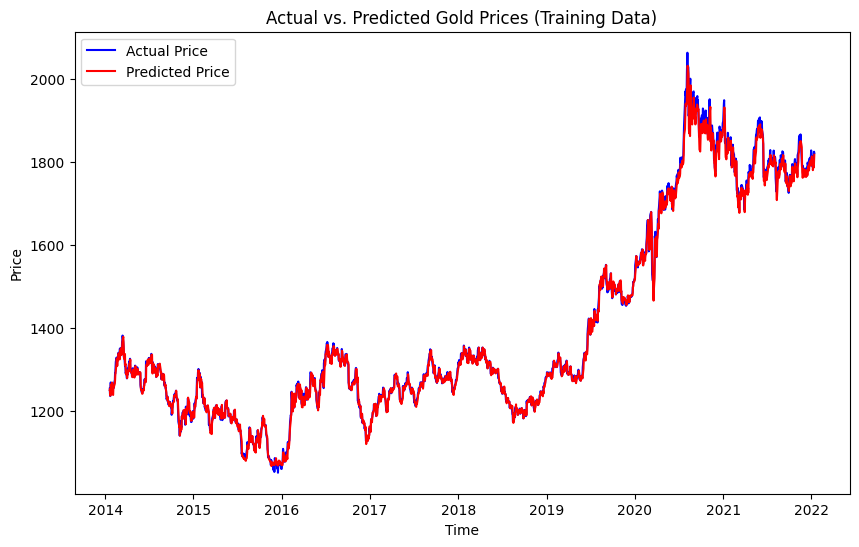

Root Mean Squared Error (RMSE): 215.1287447222792


In [ ]:
# Plotting the actual vs. predicted gold prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_train_RNN, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_gold_true, pred_gold_train_RNN))

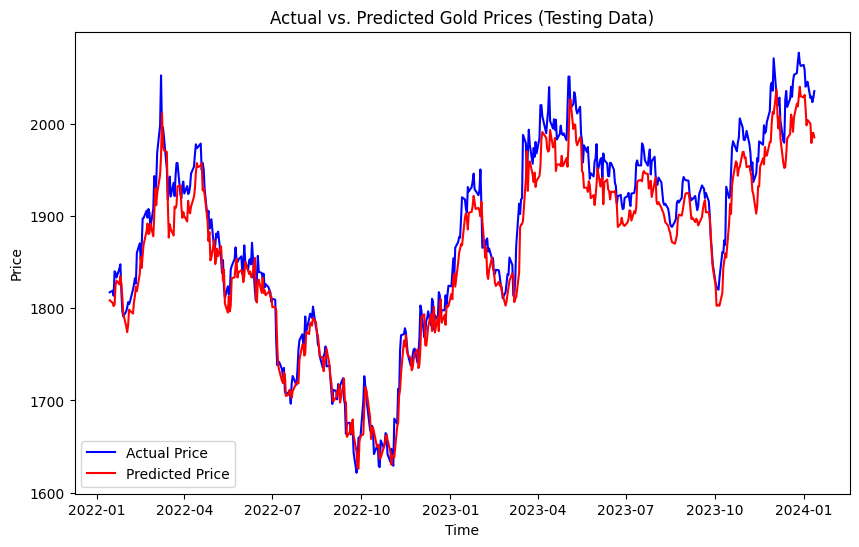

Root Mean Squared Error (RMSE): 713.7383548195609


In [ ]:
# Plotting the actual vs. predicted gold prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_test_RNN, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_gold_true, pred_gold_test_RNN))

#### Oil

In [ ]:
#daily_oil.loc['2020-04-20'] = [18.27, 20, 20.22, 17.31, 0]

In [ ]:
#Oil

# Normalize the data
daily_oil_scaled = pd.DataFrame()
daily_oil_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_oil[['Open', 'High', 'Low', 'Change %','Price']])
daily_oil_time = daily_oil.index
daily_oil_scaled.set_index(daily_oil_time,inplace = True)
daily_oil_scaled = daily_oil_scaled[::-1]

# Create sequences and labels
X_oil, y_oil = create_sequences(daily_oil_scaled, window_size)

y_oil = pd.DataFrame(y_oil).set_index(daily_oil_scaled.index[window_size:len(daily_oil_scaled)])

# Split the data into training and testing sets
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(X_oil, y_oil, test_size=0.2, shuffle=False)

# Define the model
model_RNN_Oil = Sequential([
    SimpleRNN(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    SimpleRNN(64, activation = 'relu', return_sequences=True),
    SimpleRNN(32, activation = 'relu', return_sequences=True),
    SimpleRNN(16,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_RNN_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_RNN_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_RNN_Oil_train = model_RNN_Oil.evaluate(X_train_oil, y_train_oil)
loss_RNN_Oil_test = model_RNN_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_RNN_Oil_train)
print("Test Loss:", loss_RNN_Oil_test)

#Predict
pred_oil_train_RNN = model_RNN_Oil.predict(X_train_oil)
pred_oil_train_RNN = pred_oil_train_RNN.reshape(len(pred_oil_train_RNN))

pred_oil_test_RNN = model_RNN_Oil.predict(X_test_oil)
pred_oil_test_RNN = pred_oil_test_RNN.reshape(len(pred_oil_test_RNN))

  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289

In [ ]:
# Mini model
model_RNN_Oil_mini = Sequential([
    SimpleRNN(3, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    SimpleRNN(2, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_RNN_Oil_mini.compile(optimizer='adam', loss='mse')

# Train the model
model_RNN_Oil_mini.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

loss_RNN_Oil_mini_train = model_RNN_Oil_mini.evaluate(X_train_oil, y_train_oil)
loss_RNN_Oil_mini_test = model_RNN_Oil_mini.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_RNN_Oil_mini_train)
print("Test Loss:", loss_RNN_Oil_mini_test)

#Predict
pred_oil_train_RNN_mini = model_RNN_Oil_mini.predict(X_train_oil)
pred_oil_train_RNN_mini = pred_oil_train_RNN_mini.reshape(len(pred_oil_train_RNN_mini))

pred_oil_test_RNN_mini = model_RNN_Oil.predict(X_test_oil)
pred_oil_test_RNN_mini = pred_oil_test_RNN.reshape(len(pred_oil_test_RNN_mini))

Epoch 1/50
63/63 [==============================] - 1s 8ms/step - loss: 0.5682 - val_loss: 0.2510
Epoch 2/50
63/63 [==============================] - 0s 6ms/step - loss: 0.3502 - val_loss: 0.1985
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 0.2922 - val_loss: 0.1554
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 0.2411 - val_loss: 0.1191
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 0.1972 - val_loss: 0.0894
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 0.1601 - val_loss: 0.0657
Epoch 7/50
63/63 [==============================] - 0s 6ms/step - loss: 0.1294 - val_loss: 0.0472
Epoch 8/50
63/63 [==============================] - 0s 5ms/step - loss: 0.1041 - val_loss: 0.0333
Epoch 9/50
63/63 [==============================] - 0s 5ms/step - loss: 0.0838 - val_loss: 0.0231
Epoch 10/50
63/63 [==============================] - 0s 6ms/step - loss: 0.0676 - val_loss: 0.0161
Epoch 11/50
63/63 [

In [ ]:
y_train_oil_true = pd.DataFrame(inverse_minmax_scaling(y_train_oil, min(daily_oil['Price']), max(daily_oil['Price'])))
y_test_oil_true = pd.DataFrame(inverse_minmax_scaling(y_test_oil, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_test_RNN = pd.DataFrame(inverse_minmax_scaling(pred_oil_test_RNN, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_train_RNN = pd.DataFrame(inverse_minmax_scaling(pred_oil_train_RNN, min(daily_oil['Price']), max(daily_oil['Price'])))

pred_oil_train_RNN.set_index(y_train_oil_true.index, inplace = True)
pred_oil_test_RNN.set_index(y_test_oil_true.index, inplace = True)

In [ ]:
pred_oil_test_RNN_mini = pd.DataFrame(inverse_minmax_scaling(pred_oil_test_RNN_mini, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_train_RNN_mini = pd.DataFrame(inverse_minmax_scaling(pred_oil_train_RNN_mini, min(daily_oil['Price']), max(daily_oil['Price'])))

pred_oil_train_RNN_mini.set_index(y_train_oil_true.index, inplace = True)
pred_oil_test_RNN_mini.set_index(y_test_oil_true.index, inplace = True)

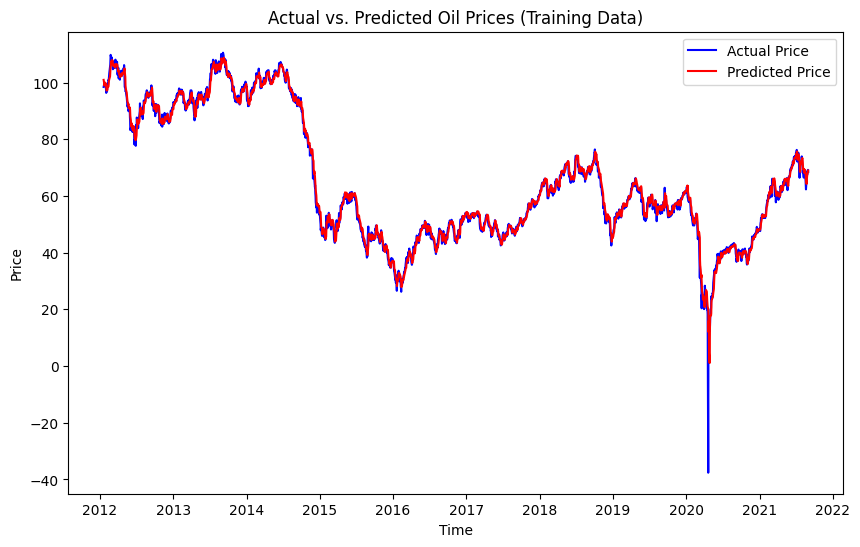

Root Mean Squared Error (RMSE): 3.8902457238463874


In [ ]:
# Plotting the actual vs. predicted oil prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_train_RNN, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_oil_true, pred_oil_train_RNN))

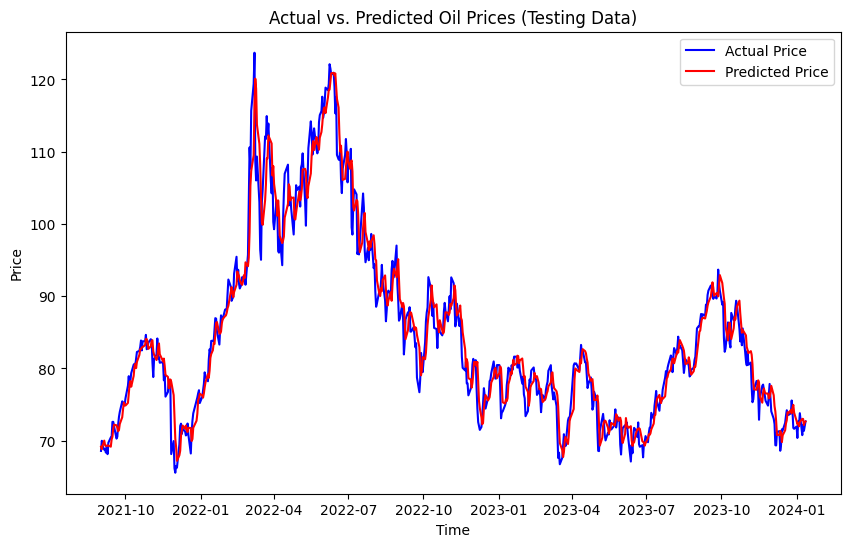

Root Mean Squared Error (RMSE): 8.38547355923431


In [ ]:
# Plotting the actual vs. predicted oil prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_test_RNN, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_oil_true, pred_oil_test_RNN))

### Using RNN model to predict stock price

#### Gold related stocks

In [ ]:
# Creating the dataframe and X,y values for Barrick
daily_barrick_scaled = pd.DataFrame()
daily_barrick_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_barrick[['Open', 'High', 'Low', 'Change %','Price']])
daily_barrick_time = daily_barrick.index
daily_barrick_scaled.set_index(daily_barrick_time,inplace = True)
daily_barrick_scaled = daily_barrick_scaled[::-1]

X_barrick, y_barrick = create_sequences(daily_barrick_scaled, window_size)
y_barrick = pd.DataFrame(y_barrick).set_index(daily_barrick_scaled.index[window_size:len(daily_barrick_scaled)])

# Create the predictions
pred_barrick_RNN = model_RNN_Gold.predict(X_barrick)
pred_barrick_RNN = pred_barrick_RNN.reshape(len(pred_barrick_RNN))

y_barrick_true = pd.DataFrame(inverse_minmax_scaling(y_barrick, min(daily_barrick['Price']), max(daily_barrick['Price'])))
pred_barrick_RNN_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_RNN, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_RNN_true.set_index(y_barrick_true.index, inplace = True)

/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ 

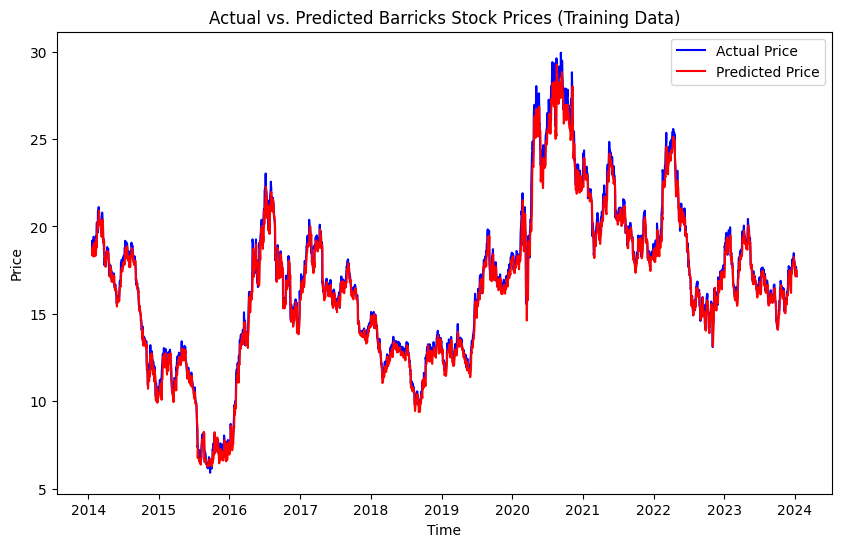

Mean Squared Error of True Data (MSE): 0.29008724497797883
Mean Squared Error of Scaled Data (MSE): 0.0005023671662930076


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_RNN_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barricks Stock Prices (Training Data)')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (MSE):", mean_squared_error(y_barrick_true, pred_barrick_RNN_true))
print("Mean Squared Error of Scaled Data (MSE):", mean_squared_error(y_barrick, pred_barrick_RNN))

In [ ]:
# Creating the dataframe and X,y values for Newmont
daily_newmont_scaled = pd.DataFrame()
daily_newmont_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_newmont[['Open', 'High', 'Low', 'Change %','Price']])
daily_newmont_time = daily_newmont.index
daily_newmont_scaled.set_index(daily_newmont_time,inplace = True)
daily_newmont_scaled = daily_newmont_scaled[::-1]

X_newmont, y_newmont = create_sequences(daily_newmont_scaled, window_size)
y_newmont = pd.DataFrame(y_newmont).set_index(daily_newmont_scaled.index[window_size:len(daily_newmont_scaled)])

# Create the predictions
pred_newmont_RNN = model_RNN_Gold.predict(X_newmont)
pred_newmont_RNN = pred_newmont_RNN.reshape(len(pred_newmont_RNN))

y_newmont_true = pd.DataFrame(inverse_minmax_scaling(y_newmont, min(daily_newmont['Price']), max(daily_newmont['Price'])))
pred_newmont_RNN_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_RNN, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_RNN_true.set_index(y_newmont_true.index, inplace = True)

/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ 

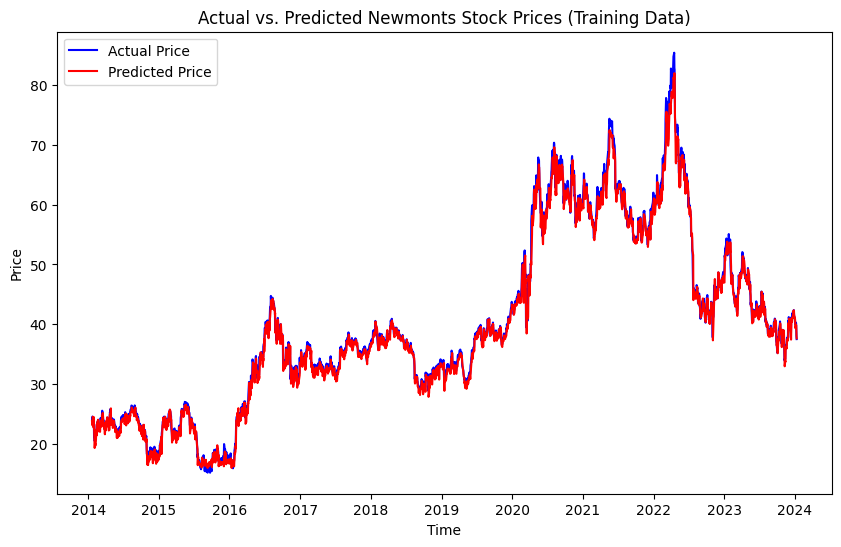

Mean Squared Error of True Data (MSE): 1.4396684817060446
Mean Squared Error of Scaled Data (MSE): 0.000291722444852658


In [ ]:
# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_RNN_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmonts Stock Prices (Training Data)')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (MSE):", mean_squared_error(y_newmont_true, pred_newmont_RNN_true))
print("Mean Squared Error of Scaled Data (MSE):", mean_squared_error(y_newmont, pred_newmont_RNN))

#### Oil related stocks

In [ ]:
# Creating the dataframe and X,y values for Chevron
daily_chevron_scaled = pd.DataFrame()
daily_chevron_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_chevron[['Open', 'High', 'Low', 'Change %','Price']])
daily_chevron_time = daily_chevron.index
daily_chevron_scaled.set_index(daily_chevron_time,inplace = True)
daily_chevron_scaled = daily_chevron_scaled[::-1]

X_chevron, y_chevron = create_sequences(daily_chevron_scaled, window_size)
y_chevron = pd.DataFrame(y_chevron).set_index(daily_chevron_scaled.index[window_size:len(daily_chevron_scaled)])

# Create the predictions
pred_chevron_RNN = model_RNN_Oil.predict(X_chevron)
pred_chevron_RNN = pred_chevron_RNN.reshape(len(pred_chevron_RNN))

y_chevron_true = pd.DataFrame(inverse_minmax_scaling(y_chevron, min(daily_chevron['Price']), max(daily_chevron['Price'])))
pred_chevron_RNN_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_RNN, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_RNN_true.set_index(y_chevron_true.index, inplace = True)

/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ 

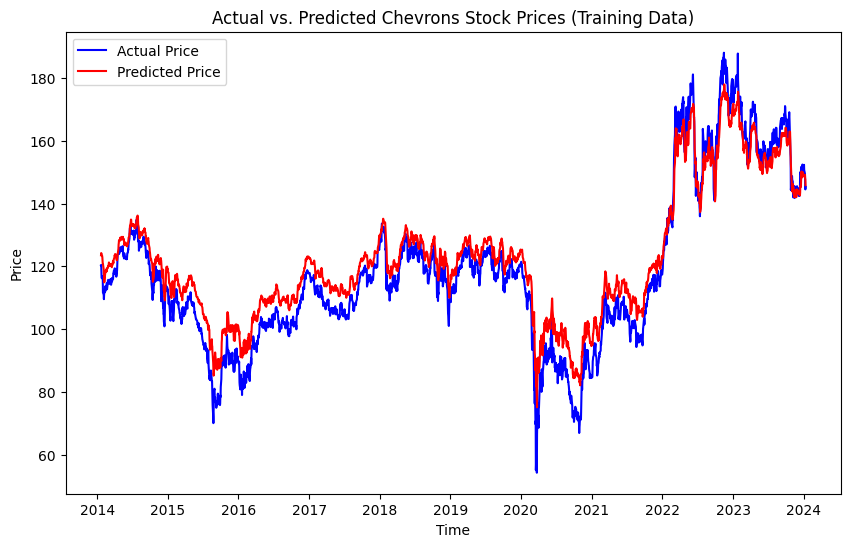

Mean Squared Error of True Data (MSE): 49.541037169636404
Mean Squared Error of Scaled Data (MSE): 0.0027660369486865255


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_RNN_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevrons Stock Prices (Training Data)')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (MSE):", mean_squared_error(y_chevron_true, pred_chevron_RNN_true))
print("Mean Squared Error of Scaled Data (MSE):", mean_squared_error(y_chevron, pred_chevron_RNN))

In [ ]:
# Creating the dataframe and X,y values for Exxon
daily_exxon_scaled = pd.DataFrame()
daily_exxon_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_exxon[['Open', 'High', 'Low', 'Change %','Price']])
daily_exxon_time = daily_exxon.index
daily_exxon_scaled.set_index(daily_exxon_time,inplace = True)
daily_exxon_scaled = daily_exxon_scaled[::-1]

X_exxon, y_exxon = create_sequences(daily_exxon_scaled, window_size)
y_exxon = pd.DataFrame(y_exxon).set_index(daily_exxon_scaled.index[window_size:len(daily_exxon_scaled)])

# Create the predictions
pred_exxon_RNN = model_RNN_Oil.predict(X_exxon)
pred_exxon_RNN = pred_exxon_RNN.reshape(len(pred_exxon_RNN))

y_exxon_true = pd.DataFrame(inverse_minmax_scaling(y_exxon, min(daily_exxon['Price']), max(daily_exxon['Price'])))
pred_exxon_RNN_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_RNN, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_RNN_true.set_index(y_exxon_true.index, inplace = True)

/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ 

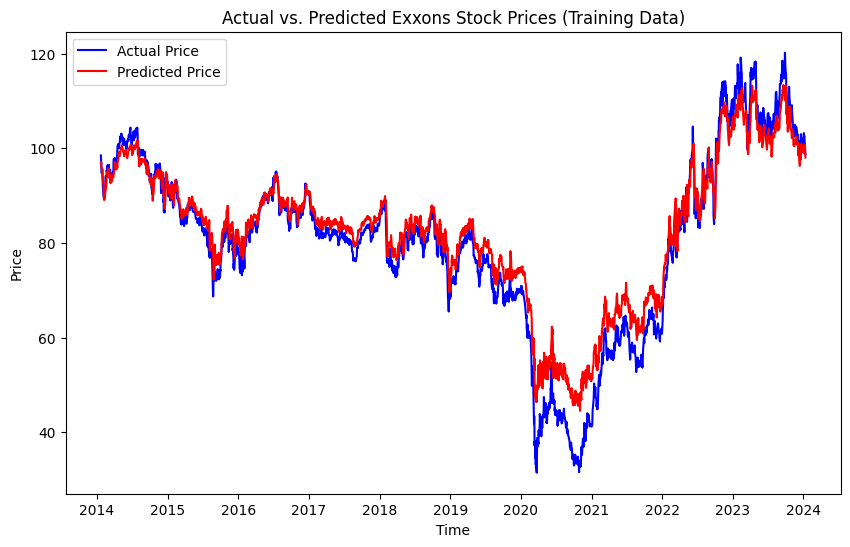

Root Mean Squared Error of True Data (RMSE): 22.827442548253515
Root Mean Squared Error of Scaled Data (RMSE): 0.0028981474702628397


In [ ]:
# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_RNN_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxons Stock Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_RNN_true))
print("Root Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_RNN))

### GRU

#### Gold

In [ ]:
#Gold

# Define the model
model_GRU_Gold = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(64, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(16, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Gold_train = model_GRU_Gold.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_test = model_GRU_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_train)
print("Test Loss:", loss_GRU_Gold_test)

#Predict
pred_gold_train_GRU = model_GRU_Gold.predict(X_train_gold)
pred_gold_train_GRU = pred_gold_train_GRU.reshape(len(pred_gold_train_GRU))

pred_gold_test_GRU = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU))

Epoch 1/50
52/52 [==============================] - 4s 22ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 2/50
52/52 [==============================] - 1s 14ms/step - loss: 5.7019e-04 - val_loss: 0.0014
Epoch 3/50
52/52 [==============================] - 1s 16ms/step - loss: 4.3929e-04 - val_loss: 9.2561e-04
Epoch 4/50
52/52 [==============================] - 1s 17ms/step - loss: 4.3184e-04 - val_loss: 8.5992e-04
Epoch 5/50
52/52 [==============================] - 1s 14ms/step - loss: 3.7305e-04 - val_loss: 8.7621e-04
Epoch 6/50
52/52 [==============================] - 1s 14ms/step - loss: 3.3299e-04 - val_loss: 0.0017
Epoch 7/50
52/52 [==============================] - 1s 16ms/step - loss: 3.3827e-04 - val_loss: 7.5532e-04
Epoch 8/50
52/52 [==============================] - 1s 15ms/step - loss: 3.0106e-04 - val_loss: 6.7105e-04
Epoch 9/50
52/52 [==============================] - 1s 14ms/step - loss: 2.7953e-04 - val_loss: 0.0028
Epoch 10/50
52/52 [==============================] - 1s 1

In [ ]:
# Mini model
model_GRU_Gold_mini = Sequential([
    GRU(3, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(2, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Gold_mini.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Gold_mini.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

loss_GRU_Gold_mini_train = model_GRU_Gold_mini.evaluate(X_train_gold, y_train_gold)
loss_GRU_Gold_mini_test = model_GRU_Gold_mini.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_GRU_Gold_mini_train)
print("Test Loss:", loss_GRU_Gold_mini_test)

#Predict
pred_gold_train_GRU_mini = model_GRU_Gold_mini.predict(X_train_gold)
pred_gold_train_GRU_mini = pred_gold_train_GRU_mini.reshape(len(pred_gold_train_GRU_mini))

pred_gold_test_GRU_mini = model_GRU_Gold.predict(X_test_gold)
pred_gold_test_GRU_mini = pred_gold_test_GRU.reshape(len(pred_gold_test_GRU_mini))

Epoch 1/50
52/52 [==============================] - 2s 10ms/step - loss: 0.0243 - val_loss: 0.0065
Epoch 2/50
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 3/50
52/52 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 4/50
52/52 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 5/50
52/52 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 6/50
52/52 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 7/50
52/52 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 8/50
52/52 [==============================] - 0s 5ms/step - loss: 9.6780e-04 - val_loss: 0.0021
Epoch 9/50
52/52 [==============================] - 0s 5ms/step - loss: 9.2250e-04 - val_loss: 0.0028
Epoch 10/50
52/52 [==============================] - 0s 6ms/step - loss: 8.7134e-04 - val_loss: 0.0020
Epoch 

In [ ]:
pred_gold_test_GRU = pd.DataFrame(inverse_minmax_scaling(pred_gold_test_GRU, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_train_GRU = pd.DataFrame(inverse_minmax_scaling(pred_gold_train_GRU, min(daily_gold['Price']), max(daily_gold['Price'])))

pred_gold_train_GRU.set_index(y_train_gold_true.index, inplace = True)
pred_gold_test_GRU.set_index(y_test_gold_true.index, inplace = True)

In [ ]:
pred_gold_test_GRU_mini = pd.DataFrame(inverse_minmax_scaling(pred_gold_test_GRU_mini, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_train_GRU_mini = pd.DataFrame(inverse_minmax_scaling(pred_gold_train_GRU_mini, min(daily_gold['Price']), max(daily_gold['Price'])))

pred_gold_train_GRU_mini.set_index(y_train_gold_true.index, inplace = True)
pred_gold_test_GRU_mini.set_index(y_test_gold_true.index, inplace = True)

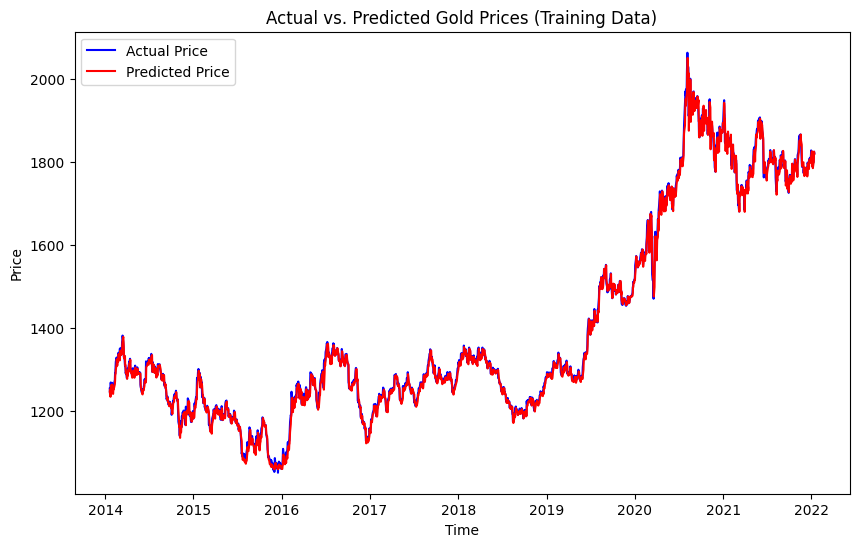

Root Mean Squared Error (RMSE): 177.56613727807562


In [ ]:
# Plotting the actual vs. predicted gold prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_train_GRU, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_gold_true, pred_gold_train_GRU))

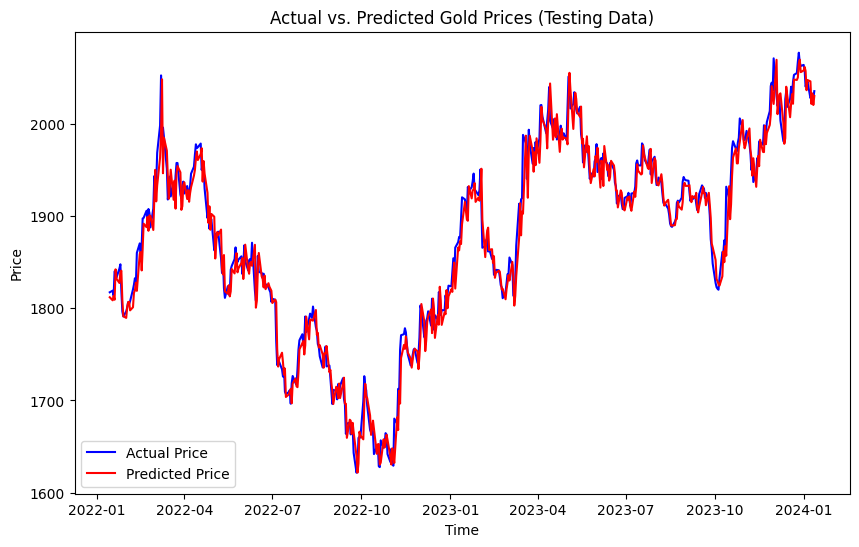

Root Mean Squared Error (RMSE): 326.0989669317497


In [ ]:
# Plotting the actual vs. predicted gold prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_test_GRU, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_gold_true, pred_gold_test_GRU))

#### Oil

In [ ]:
#Oil

# Define the model
model_GRU_Oil = Sequential([
    GRU(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(64, activation = 'relu', return_sequences=True),
    GRU(32, activation = 'relu', return_sequences=True),
    GRU(16,  activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_GRU_Oil_train = model_GRU_Oil.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_test = model_GRU_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_train)
print("Test Loss:", loss_GRU_Oil_test)

#Predict
pred_oil_train_GRU = model_GRU_Oil.predict(X_train_oil)
pred_oil_train_GRU = pred_oil_train_GRU.reshape(len(pred_oil_train_GRU))

pred_oil_test_GRU = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU))

Epoch 1/50
63/63 [==============================] - 5s 28ms/step - loss: 0.0614 - val_loss: 0.0033
Epoch 2/50
63/63 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 8.3659e-04
Epoch 3/50
63/63 [==============================] - 1s 21ms/step - loss: 1.8713e-04 - val_loss: 6.3514e-04
Epoch 4/50
63/63 [==============================] - 1s 20ms/step - loss: 1.7290e-04 - val_loss: 5.9665e-04
Epoch 5/50
63/63 [==============================] - 1s 21ms/step - loss: 1.7942e-04 - val_loss: 5.9023e-04
Epoch 6/50
63/63 [==============================] - 1s 21ms/step - loss: 1.7357e-04 - val_loss: 5.7566e-04
Epoch 7/50
63/63 [==============================] - 1s 21ms/step - loss: 1.6802e-04 - val_loss: 5.4835e-04
Epoch 8/50
63/63 [==============================] - 1s 20ms/step - loss: 1.6906e-04 - val_loss: 5.5063e-04
Epoch 9/50
63/63 [==============================] - 1s 21ms/step - loss: 1.7363e-04 - val_loss: 5.7414e-04
Epoch 10/50
63/63 [==============================

In [ ]:
# Mini model
model_GRU_Oil_mini = Sequential([
    GRU(3, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    GRU(2, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_GRU_Oil_mini.compile(optimizer='adam', loss='mse')

# Train the model
model_GRU_Oil_mini.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

loss_GRU_Oil_mini_train = model_GRU_Oil_mini.evaluate(X_train_oil, y_train_oil)
loss_GRU_Oil_mini_test = model_GRU_Oil_mini.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_GRU_Oil_mini_train)
print("Test Loss:", loss_GRU_Oil_mini_test)

#Predict
pred_oil_train_GRU_mini = model_GRU_Oil_mini.predict(X_train_oil)
pred_oil_train_GRU_mini = pred_oil_train_GRU_mini.reshape(len(pred_oil_train_GRU_mini))

pred_oil_test_GRU_mini = model_GRU_Oil.predict(X_test_oil)
pred_oil_test_GRU_mini = pred_oil_test_GRU.reshape(len(pred_oil_test_GRU_mini))

Epoch 1/50
63/63 [==============================] - 3s 14ms/step - loss: 0.1133 - val_loss: 0.0111
Epoch 2/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0055
Epoch 3/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 4/50
63/63 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 6.2839e-04
Epoch 5/50
63/63 [==============================] - 0s 7ms/step - loss: 2.5626e-04 - val_loss: 4.3477e-04
Epoch 6/50
63/63 [==============================] - 0s 8ms/step - loss: 1.2890e-04 - val_loss: 4.0206e-04
Epoch 7/50
63/63 [==============================] - 0s 7ms/step - loss: 1.1009e-04 - val_loss: 4.0276e-04
Epoch 8/50
63/63 [==============================] - 0s 7ms/step - loss: 1.0675e-04 - val_loss: 4.0148e-04
Epoch 9/50
63/63 [==============================] - 0s 7ms/step - loss: 1.0495e-04 - val_loss: 3.9978e-04
Epoch 10/50
63/63 [==============================] - 0s 7ms/step - loss: 

In [ ]:
pred_oil_test_GRU = pd.DataFrame(inverse_minmax_scaling(pred_oil_test_GRU, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_train_GRU = pd.DataFrame(inverse_minmax_scaling(pred_oil_train_GRU, min(daily_oil['Price']), max(daily_oil['Price'])))

pred_oil_train_GRU.set_index(y_train_oil_true.index, inplace = True)
pred_oil_test_GRU.set_index(y_test_oil_true.index, inplace = True)

In [ ]:
pred_oil_test_GRU_mini = pd.DataFrame(inverse_minmax_scaling(pred_oil_test_GRU_mini, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_train_GRU_mini = pd.DataFrame(inverse_minmax_scaling(pred_oil_train_GRU_mini, min(daily_oil['Price']), max(daily_oil['Price'])))

pred_oil_train_GRU_mini.set_index(y_train_oil_true.index, inplace = True)
pred_oil_test_GRU_mini.set_index(y_test_oil_true.index, inplace = True)

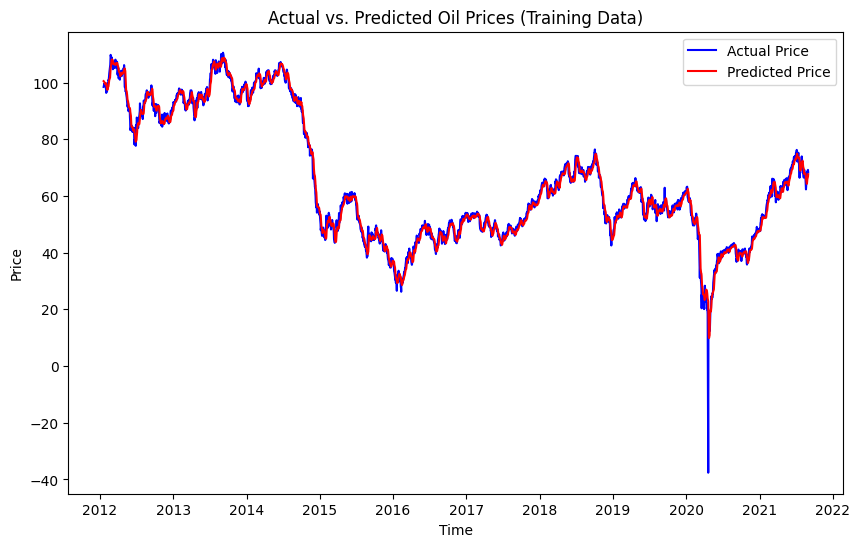

Root Mean Squared Error (RMSE): 5.094957974193358


In [ ]:
# Plotting the actual vs. predicted oil prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_train_GRU, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_oil_true, pred_oil_train_GRU))

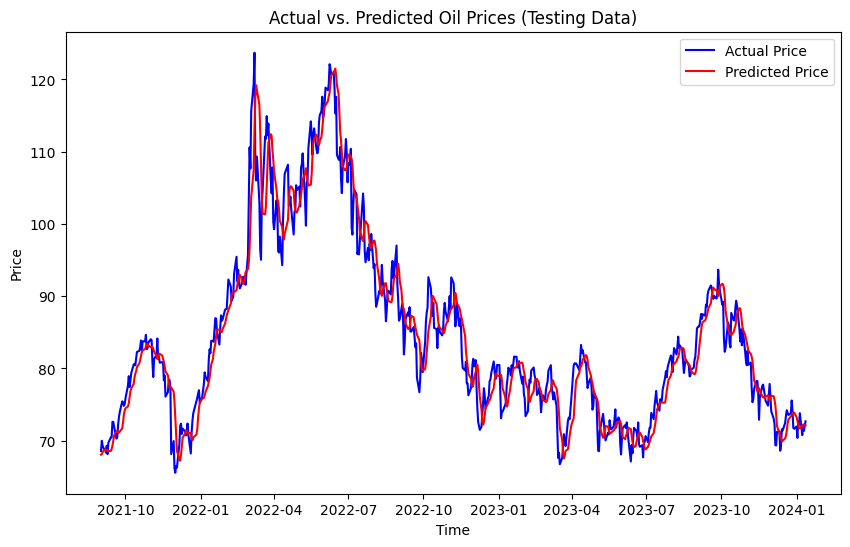

Root Mean Squared Error (RMSE): 12.2106517858927


In [ ]:
# Plotting the actual vs. predicted oil prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_test_GRU, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_oil_true, pred_oil_test_GRU))

### Using GRU model to predict stock price

#### Gold related stocks

In [ ]:
# Create the predictions
pred_barrick_GRU = model_GRU_Gold.predict(X_barrick)
pred_barrick_GRU = pred_barrick_GRU.reshape(len(pred_barrick_GRU))

pred_barrick_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_GRU, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_GRU_true.set_index(y_barrick_true.index, inplace = True)

79/79 [==============================] - 0s 4ms/step


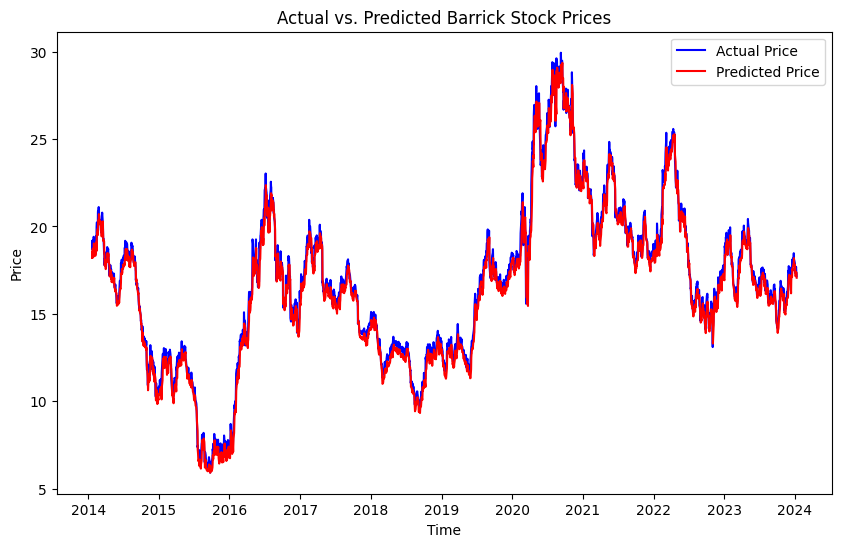

Root Mean Squared Error of True Data (RMSE): 0.30069860622122874
Root Mean Squared Error of Scaled Data(RMSE): 0.0005207436399933778


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_GRU_true))
print("Root Mean Squared Error of Scaled Data(RMSE):", mean_squared_error(y_barrick, pred_barrick_GRU))

In [ ]:
# Create the predictions
pred_newmont_GRU = model_GRU_Gold.predict(X_newmont)
pred_newmont_GRU = pred_newmont_GRU.reshape(len(pred_newmont_GRU))

pred_newmont_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_GRU, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_GRU_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 0s 4ms/step


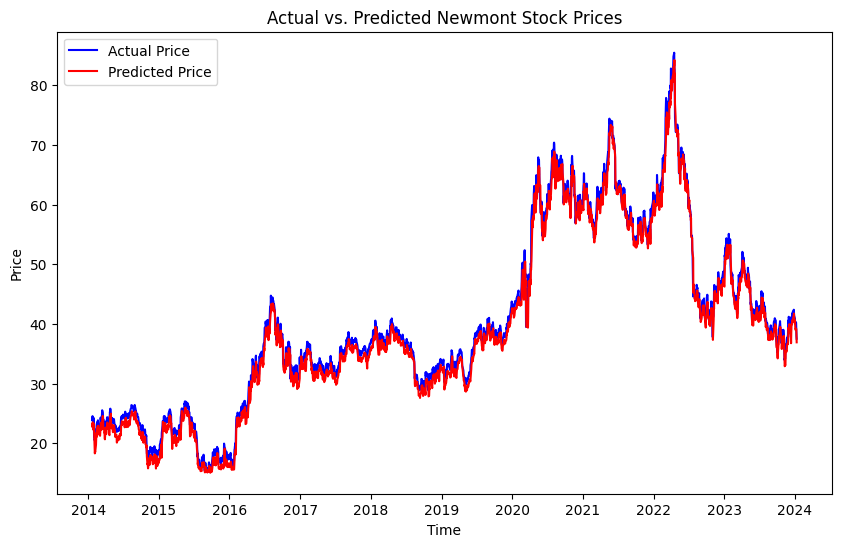

Root Mean Squared Error of True Data (RMSE): 2.146889514625789
Root Mean Squared Error (RMSE): 0.0004350278627880642


In [ ]:
# Plotting the actual vs. predicted newmont stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_GRU_true))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_newmont, pred_newmont_GRU))

#### Oil related stocks

In [ ]:
# Create the predictions
pred_chevron_GRU = model_GRU_Oil.predict(X_chevron)
pred_chevron_GRU = pred_chevron_GRU.reshape(len(pred_chevron_GRU))

pred_chevron_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_GRU, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_GRU_true.set_index(y_chevron_true.index, inplace = True)

79/79 [==============================] - 0s 4ms/step


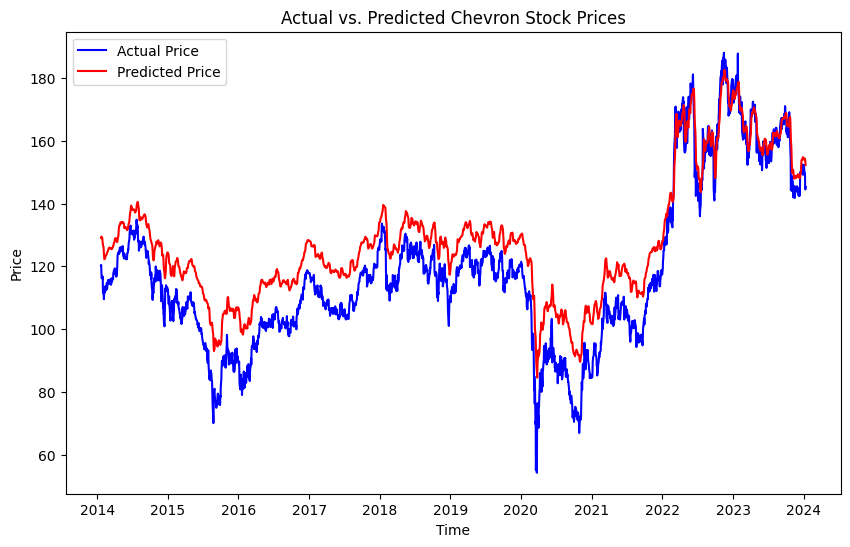

Root Mean Squared Error of True Data (RMSE): 134.48601918569145
Root Mean Squared Error of Scaled Data (RMSE): 0.007508791745994149


In [ ]:
# Plotting the actual vs. predicted chevron stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_GRU_true))
print("Root Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_GRU))

In [ ]:
# Create the predictions
pred_exxon_GRU = model_GRU_Oil.predict(X_exxon)
pred_exxon_GRU = pred_exxon_GRU.reshape(len(pred_exxon_GRU))

pred_exxon_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_GRU, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_GRU_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 0s 4ms/step


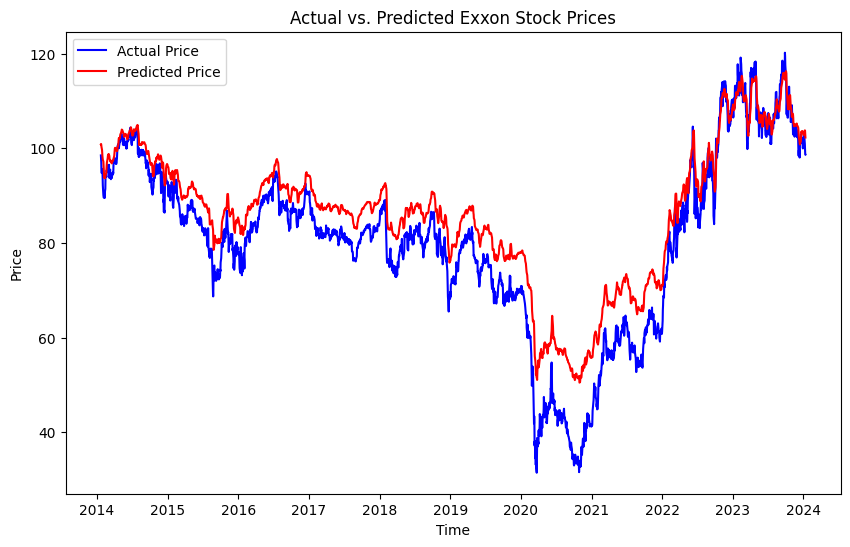

Root Mean Squared Error of True Data (RMSE): 54.13942179655557
Root Mean Squared Error of Scaled Data (RMSE): 0.006873482163919057


In [ ]:
# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_GRU_true))
print("Root Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_GRU))

### LSTM

#### Gold

In [ ]:
#Gold

# Define the model
model_LSTM_Gold = Sequential([
    LSTM(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    LSTM(64, activation = 'relu', return_sequences=True),
    LSTM(32, activation = 'relu', return_sequences=True),
    LSTM(16, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_LSTM_Gold.compile(optimizer='adam', loss='mse')

# Train the model
model_LSTM_Gold.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_LSTM_Gold_train = model_LSTM_Gold.evaluate(X_train_gold, y_train_gold)
loss_LSTM_Gold_test = model_LSTM_Gold.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_LSTM_Gold_train)
print("Test Loss:", loss_LSTM_Gold_test)

#Predict
pred_gold_train_LSTM = model_LSTM_Gold.predict(X_train_gold)
pred_gold_train_LSTM = pred_gold_train_LSTM.reshape(len(pred_gold_train_LSTM))

pred_gold_test_LSTM = model_LSTM_Gold.predict(X_test_gold)
pred_gold_test_LSTM = pred_gold_test_LSTM.reshape(len(pred_gold_test_LSTM))

Epoch 1/50
52/52 [==============================] - 4s 27ms/step - loss: 0.0272 - val_loss: 0.3569
Epoch 2/50
52/52 [==============================] - 1s 17ms/step - loss: 0.0028 - val_loss: 0.1045
Epoch 3/50
52/52 [==============================] - 1s 18ms/step - loss: 9.8052e-04 - val_loss: 0.0538
Epoch 4/50
52/52 [==============================] - 1s 20ms/step - loss: 6.2415e-04 - val_loss: 0.0114
Epoch 5/50
52/52 [==============================] - 1s 18ms/step - loss: 5.1558e-04 - val_loss: 0.0102
Epoch 6/50
52/52 [==============================] - 1s 18ms/step - loss: 4.5810e-04 - val_loss: 0.0026
Epoch 7/50
52/52 [==============================] - 1s 20ms/step - loss: 4.6224e-04 - val_loss: 0.0054
Epoch 8/50
52/52 [==============================] - 1s 17ms/step - loss: 4.0837e-04 - val_loss: 0.0043
Epoch 9/50
52/52 [==============================] - 1s 19ms/step - loss: 4.4833e-04 - val_loss: 0.0028
Epoch 10/50
52/52 [==============================] - 1s 18ms/step - loss: 3.9006e

In [ ]:
# Mini model
model_LSTM_Gold_mini = Sequential([
    LSTM(3, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    LSTM(2, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_LSTM_Gold_mini.compile(optimizer='adam', loss='mse')

# Train the model
model_LSTM_Gold_mini.fit(X_train_gold, y_train_gold, epochs=50, batch_size=32, validation_split=0.2)

loss_LSTM_Gold_mini_train = model_LSTM_Gold_mini.evaluate(X_train_gold, y_train_gold)
loss_LSTM_Gold_mini_test = model_LSTM_Gold_mini.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_LSTM_Gold_mini_train)
print("Test Loss:", loss_LSTM_Gold_mini_test)

#Predict
pred_gold_train_LSTM_mini = model_LSTM_Gold_mini.predict(X_train_gold)
pred_gold_train_LSTM_mini = pred_gold_train_LSTM_mini.reshape(len(pred_gold_train_LSTM_mini))

pred_gold_test_LSTM_mini = model_LSTM_Gold.predict(X_test_gold)
pred_gold_test_LSTM_mini = pred_gold_test_LSTM.reshape(len(pred_gold_test_LSTM_mini))

Epoch 1/50
52/52 [==============================] - 2s 11ms/step - loss: 0.0159 - val_loss: 0.1434
Epoch 2/50
52/52 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.1130
Epoch 3/50
52/52 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0571
Epoch 4/50
52/52 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0154
Epoch 5/50
52/52 [==============================] - 0s 5ms/step - loss: 4.4746e-04 - val_loss: 0.0017
Epoch 6/50
52/52 [==============================] - 0s 5ms/step - loss: 2.0657e-04 - val_loss: 7.0938e-04
Epoch 7/50
52/52 [==============================] - 0s 6ms/step - loss: 1.9714e-04 - val_loss: 7.3387e-04
Epoch 8/50
52/52 [==============================] - 0s 5ms/step - loss: 1.9259e-04 - val_loss: 7.6704e-04
Epoch 9/50
52/52 [==============================] - 0s 5ms/step - loss: 1.9159e-04 - val_loss: 7.4141e-04
Epoch 10/50
52/52 [==============================] - 0s 6ms/step - loss: 1.8750e-

In [ ]:
pred_gold_test_LSTM = pd.DataFrame(inverse_minmax_scaling(pred_gold_test_LSTM, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_train_LSTM = pd.DataFrame(inverse_minmax_scaling(pred_gold_train_LSTM, min(daily_gold['Price']), max(daily_gold['Price'])))

pred_gold_train_LSTM.set_index(y_train_gold_true.index, inplace = True)
pred_gold_test_LSTM.set_index(y_test_gold_true.index, inplace = True)

In [ ]:
pred_gold_test_LSTM_mini = pd.DataFrame(inverse_minmax_scaling(pred_gold_test_LSTM_mini, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_train_LSTM_mini = pd.DataFrame(inverse_minmax_scaling(pred_gold_train_LSTM_mini, min(daily_gold['Price']), max(daily_gold['Price'])))

pred_gold_train_LSTM_mini.set_index(y_train_gold_true.index, inplace = True)
pred_gold_test_LSTM_mini.set_index(y_test_gold_true.index, inplace = True)

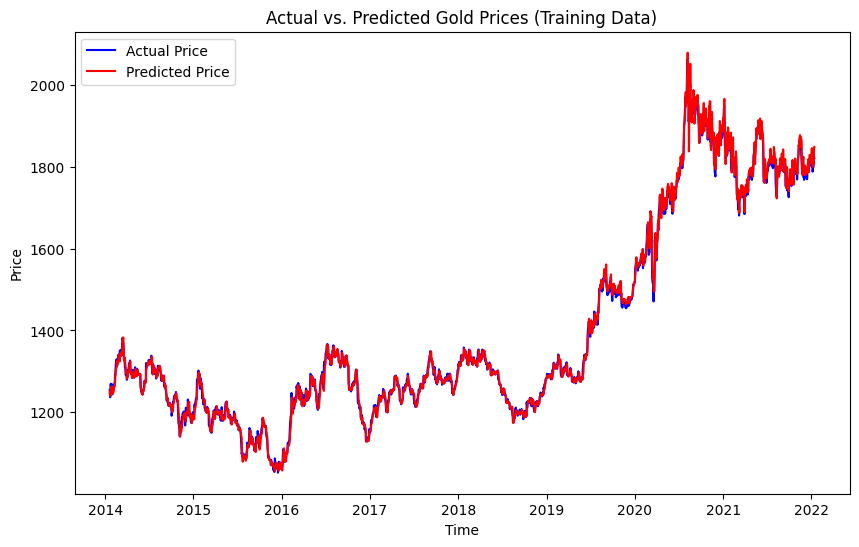

Root Mean Squared Error (RMSE): 222.97007473918532


In [ ]:
# Plotting the actual vs. predicted gold prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_train_LSTM, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_gold_true, pred_gold_train_LSTM))

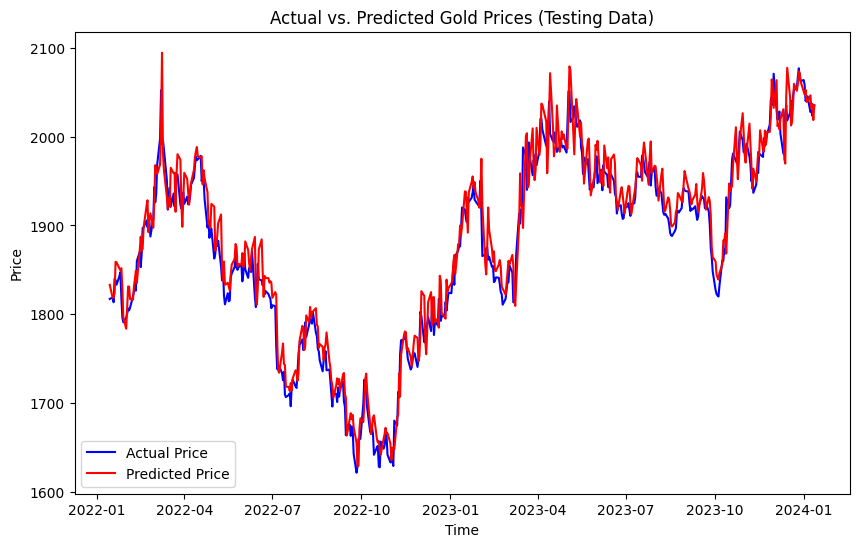

Root Mean Squared Error (RMSE): 546.199361404031


In [ ]:
# Plotting the actual vs. predicted gold prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_test_LSTM, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_gold_true, pred_gold_test_LSTM))

#### Oil

In [ ]:
#Oil

# Define the model
model_LSTM_Oil = Sequential([
    LSTM(128, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    LSTM(64, activation = 'relu', return_sequences=True),
    LSTM(32, activation = 'relu', return_sequences=True),
    LSTM(16, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_LSTM_Oil.compile(optimizer='adam', loss='mse')

# Train the model
model_LSTM_Oil.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_LSTM_Oil_train = model_LSTM_Oil.evaluate(X_train_oil, y_train_oil)
loss_LSTM_Oil_test = model_LSTM_Oil.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_LSTM_Oil_train)
print("Test Loss:", loss_LSTM_Oil_test)

#Predict
pred_oil_train_LSTM = model_LSTM_Oil.predict(X_train_oil)
pred_oil_train_LSTM = pred_oil_train_LSTM.reshape(len(pred_oil_train_LSTM))

pred_oil_test_LSTM = model_LSTM_Oil.predict(X_test_oil)
pred_oil_test_LSTM = pred_oil_test_LSTM.reshape(len(pred_oil_test_LSTM))

Epoch 1/50
63/63 [==============================] - 6s 33ms/step - loss: 0.1976 - val_loss: 0.0011
Epoch 2/50
63/63 [==============================] - 1s 23ms/step - loss: 3.6771e-04 - val_loss: 5.9831e-04
Epoch 3/50
63/63 [==============================] - 1s 22ms/step - loss: 1.9963e-04 - val_loss: 5.9506e-04
Epoch 4/50
63/63 [==============================] - 1s 22ms/step - loss: 1.9534e-04 - val_loss: 5.9661e-04
Epoch 5/50
63/63 [==============================] - 1s 21ms/step - loss: 2.0001e-04 - val_loss: 5.9894e-04
Epoch 6/50
63/63 [==============================] - 1s 21ms/step - loss: 1.9369e-04 - val_loss: 6.0376e-04
Epoch 7/50
63/63 [==============================] - 1s 21ms/step - loss: 1.8983e-04 - val_loss: 5.9851e-04
Epoch 8/50
63/63 [==============================] - 1s 21ms/step - loss: 1.9165e-04 - val_loss: 6.0438e-04
Epoch 9/50
63/63 [==============================] - 1s 21ms/step - loss: 1.9674e-04 - val_loss: 6.1789e-04
Epoch 10/50
63/63 [==========================

In [ ]:
# Mini model
model_LSTM_Oil_mini = Sequential([
    LSTM(3, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    LSTM(2, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_LSTM_Oil_mini.compile(optimizer='adam', loss='mse')

# Train the model
model_LSTM_Oil_mini.fit(X_train_oil, y_train_oil, epochs=50, batch_size=32, validation_split=0.2)

loss_LSTM_Oil_mini_train = model_LSTM_Oil_mini.evaluate(X_train_oil, y_train_oil)
loss_LSTM_Oil_mini_test = model_LSTM_Oil_mini.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_LSTM_Oil_mini_train)
print("Test Loss:", loss_LSTM_Oil_mini_test)

#Predict
pred_oil_train_LSTM_mini = model_LSTM_Oil_mini.predict(X_train_oil)
pred_oil_train_LSTM_mini = pred_oil_train_LSTM_mini.reshape(len(pred_oil_train_LSTM_mini))

pred_oil_test_LSTM_mini = model_LSTM_Oil.predict(X_test_oil)
pred_oil_test_LSTM_mini = pred_oil_test_LSTM.reshape(len(pred_oil_test_LSTM_mini))

Epoch 1/50
63/63 [==============================] - 2s 12ms/step - loss: 0.4142 - val_loss: 0.2421
Epoch 2/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3415 - val_loss: 0.1885
Epoch 3/50
63/63 [==============================] - 0s 8ms/step - loss: 0.2795 - val_loss: 0.1441
Epoch 4/50
63/63 [==============================] - 0s 8ms/step - loss: 0.2270 - val_loss: 0.1081
Epoch 5/50
63/63 [==============================] - 0s 8ms/step - loss: 0.1831 - val_loss: 0.0794
Epoch 6/50
63/63 [==============================] - 0s 7ms/step - loss: 0.1469 - val_loss: 0.0570
Epoch 7/50
63/63 [==============================] - 0s 7ms/step - loss: 0.1174 - val_loss: 0.0401
Epoch 8/50
63/63 [==============================] - 0s 8ms/step - loss: 0.0935 - val_loss: 0.0278
Epoch 9/50
63/63 [==============================] - 0s 8ms/step - loss: 0.0747 - val_loss: 0.0191
Epoch 10/50
63/63 [==============================] - 0s 7ms/step - loss: 0.0600 - val_loss: 0.0135
Epoch 11/50
63/63 

In [ ]:
pred_oil_test_LSTM = pd.DataFrame(inverse_minmax_scaling(pred_oil_test_LSTM, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_train_LSTM = pd.DataFrame(inverse_minmax_scaling(pred_oil_train_LSTM, min(daily_oil['Price']), max(daily_oil['Price'])))

pred_oil_train_LSTM.set_index(y_train_oil_true.index, inplace = True)
pred_oil_test_LSTM.set_index(y_test_oil_true.index, inplace = True)

In [ ]:
pred_oil_test_LSTM_mini = pd.DataFrame(inverse_minmax_scaling(pred_oil_test_LSTM_mini, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_train_LSTM_mini = pd.DataFrame(inverse_minmax_scaling(pred_oil_train_LSTM_mini, min(daily_oil['Price']), max(daily_oil['Price'])))

pred_oil_train_LSTM_mini.set_index(y_train_oil_true.index, inplace = True)
pred_oil_test_LSTM_mini.set_index(y_test_oil_true.index, inplace = True)

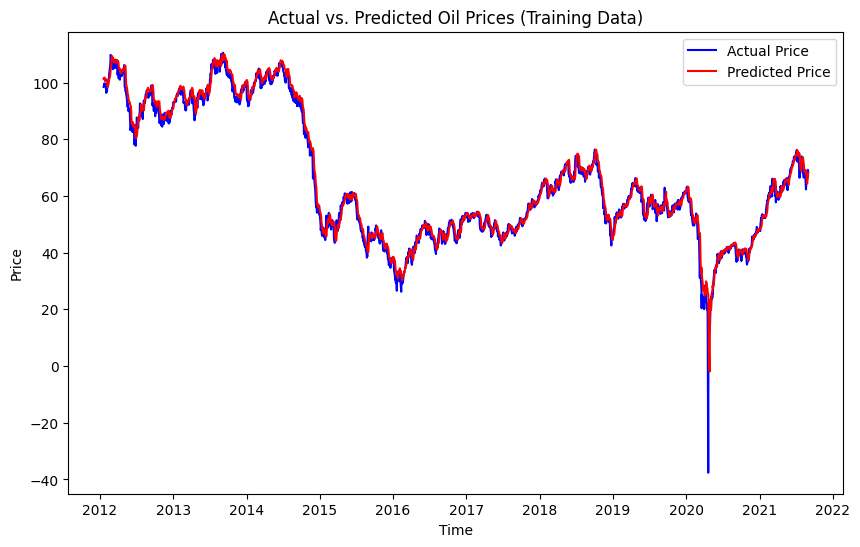

Root Mean Squared Error (RMSE): 7.712811203861746


In [ ]:
# Plotting the actual vs. predicted oil prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_train_LSTM, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_oil_true, pred_oil_train_LSTM))

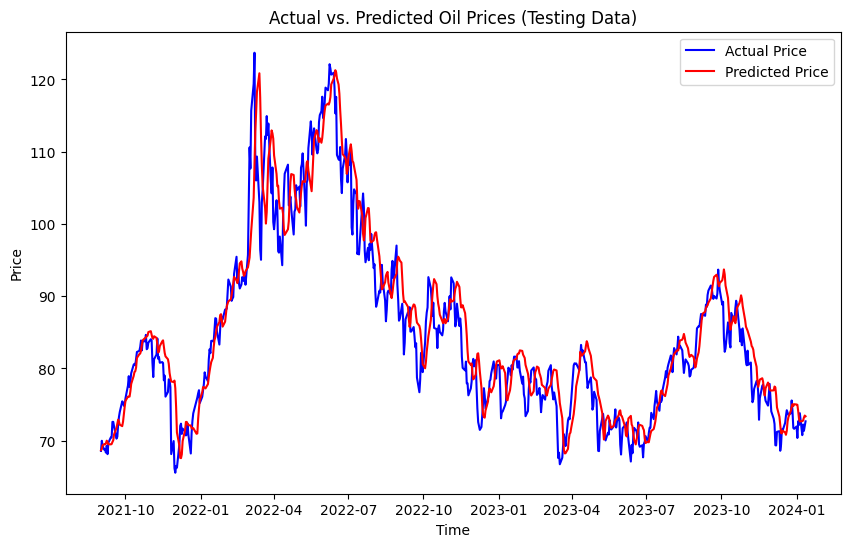

Root Mean Squared Error (RMSE): 18.76091452878497


In [ ]:
# Plotting the actual vs. predicted oil prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_test_LSTM, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_oil_true, pred_oil_test_LSTM))

### Using LSTM model to predict stock price

#### Gold related stocks

In [ ]:
# Create the predictions
pred_barrick_LSTM = model_LSTM_Gold.predict(X_barrick)
pred_barrick_LSTM = pred_barrick_LSTM.reshape(len(pred_barrick_LSTM))

pred_barrick_LSTM_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_LSTM, min(daily_barrick['Price']), max(daily_barrick['Price'])))

pred_barrick_LSTM_true.set_index(y_barrick_true.index, inplace = True)

79/79 [==============================] - 0s 6ms/step


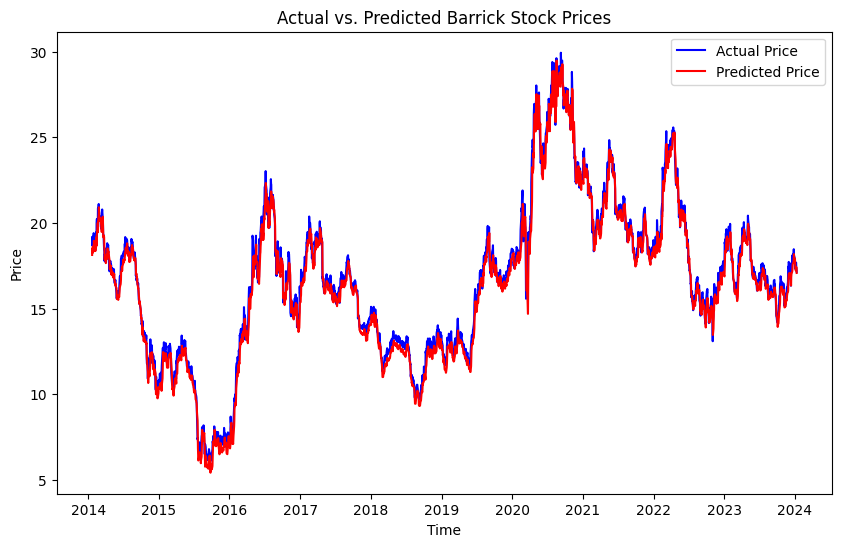

Root Mean Squared Error of True Data (RMSE): 0.3378447420500451
Root Mean Squared Error of Scaled Data (RMSE): 0.0005850725658192011


In [ ]:
# Plotting the actual vs. predicted barrick stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_LSTM_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barrick Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_barrick_true, pred_barrick_LSTM_true))
print("Root Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_barrick, pred_barrick_LSTM))

In [ ]:
# Create the predictions
pred_newmont_LSTM = model_LSTM_Gold.predict(X_newmont)
pred_newmont_LSTM = pred_newmont_LSTM.reshape(len(pred_newmont_LSTM))

pred_newmont_LSTM_true = pd.DataFrame(inverse_minmax_scaling(pred_newmont_LSTM, min(daily_newmont['Price']), max(daily_newmont['Price'])))

pred_newmont_LSTM_true.set_index(y_newmont_true.index, inplace = True)

79/79 [==============================] - 0s 5ms/step


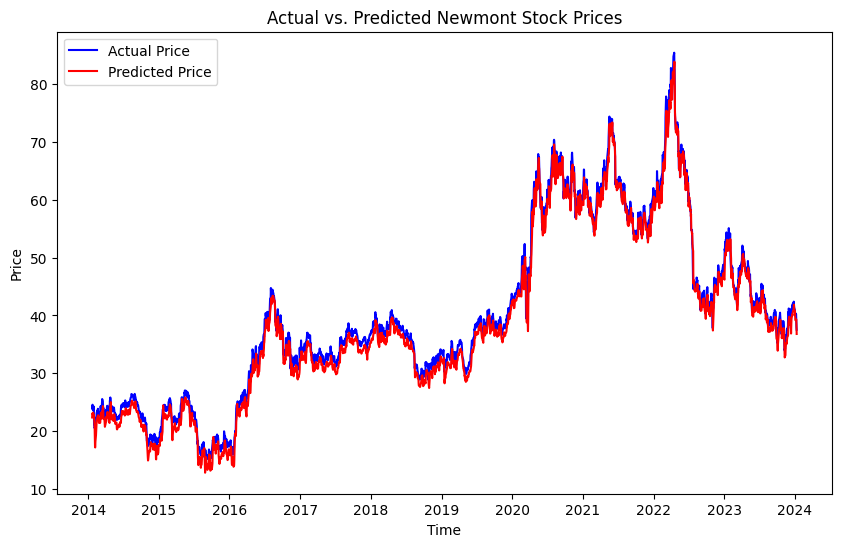

Root Mean Squared Error of True Data (RMSE): 2.677896752467707
Root Mean Squared Error of Scaled Data (RMSE): 0.0005426267165704885


In [ ]:
# Plotting the actual vs. predicted gold stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_newmont_true, label='Actual Price', color='blue')
plt.plot(pred_newmont_LSTM_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Newmont Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_newmont_true, pred_newmont_LSTM_true))
print("Root Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_newmont, pred_newmont_LSTM))

#### Oil related stocks

In [ ]:
# Create the predictions
pred_chevron_LSTM = model_LSTM_Oil.predict(X_chevron)
pred_chevron_LSTM = pred_chevron_LSTM.reshape(len(pred_chevron_LSTM))

pred_chevron_LSTM_true = pd.DataFrame(inverse_minmax_scaling(pred_chevron_LSTM, min(daily_chevron['Price']), max(daily_chevron['Price'])))

pred_chevron_LSTM_true.set_index(y_chevron_true.index, inplace = True)

79/79 [==============================] - 0s 5ms/step


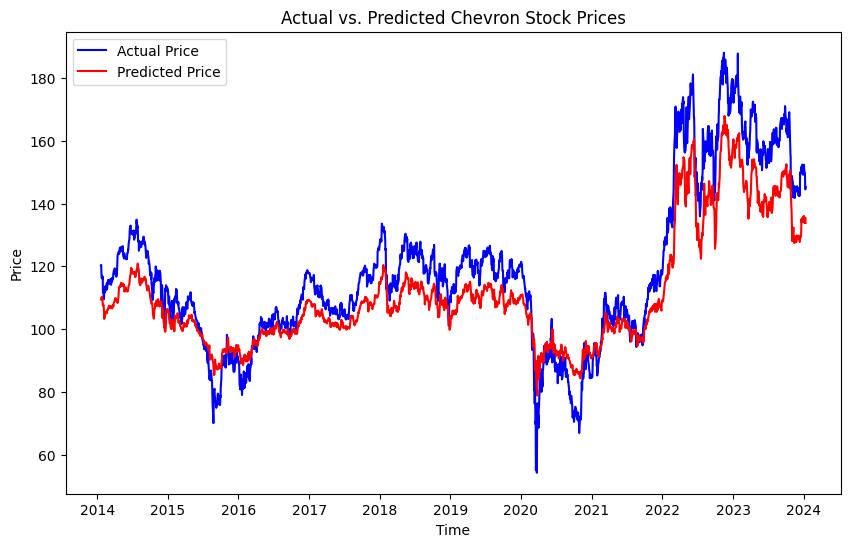

Root Mean Squared Error of True Data (RMSE): 113.48787532277272
Root Mean Squared Error of Scaled Data (RMSE): 0.006336400540029202


In [ ]:
# Plotting the actual vs. predicted gold stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_chevron_true, label='Actual Price', color='blue')
plt.plot(pred_chevron_LSTM_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Chevron Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_chevron_true, pred_chevron_LSTM_true))
print("Root Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_chevron, pred_chevron_LSTM))

In [ ]:
# Create the predictions
pred_exxon_LSTM = model_LSTM_Oil.predict(X_exxon)
pred_exxon_LSTM = pred_exxon_LSTM.reshape(len(pred_exxon_LSTM))

pred_exxon_LSTM_true = pd.DataFrame(inverse_minmax_scaling(pred_exxon_LSTM, min(daily_exxon['Price']), max(daily_exxon['Price'])))

pred_exxon_LSTM_true.set_index(y_exxon_true.index, inplace = True)

79/79 [==============================] - 0s 6ms/step


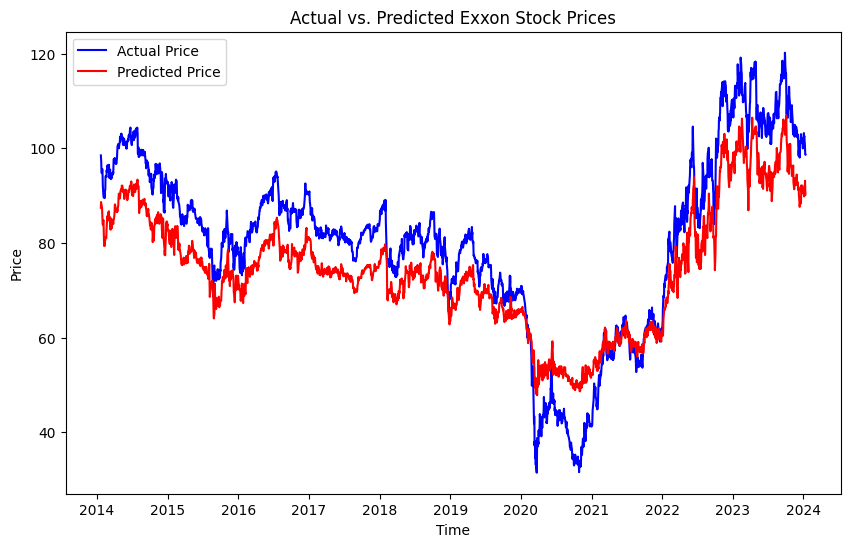

Root Mean Squared Error of True Data (RMSE): 78.72662729249295
Root Mean Squared Error of Scaled Data (RMSE): 0.009995050136592682


In [ ]:
# Plotting the actual vs. predicted exxon stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_exxon_true, label='Actual Price', color='blue')
plt.plot(pred_exxon_LSTM_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Exxon Stock Prices')
plt.legend()
plt.show()

print("Root Mean Squared Error of True Data (RMSE):", mean_squared_error(y_exxon_true, pred_exxon_LSTM_true))
print("Root Mean Squared Error of Scaled Data (RMSE):", mean_squared_error(y_exxon, pred_exxon_LSTM))

In [ ]:
daily_barrick

Price   Open   High    Low Change %
Date                                           
2024-01-11  17.15  17.38  17.49  16.94   -0.011
2024-01-10  17.34  17.44  17.52  17.20  -0.0034
2024-01-09  17.40  17.69  17.70  17.37  -0.0164
2024-01-08  17.69  17.39  17.92  17.31   0.0114
2024-01-05  17.49  17.44  17.72  17.26   0.0081
...           ...    ...    ...    ...      ...
2014-01-17  18.66  18.34  18.79  18.34   0.0304
2014-01-16  18.11  18.09  18.20  17.85   0.0095
2014-01-15  17.94  17.54  18.03  17.48   0.0136
2014-01-14  17.70  17.99  18.16  17.59  -0.0205
2014-01-13  18.07  18.03  18.10  17.59  -0.0006

[2517 rows x 5 columns]

In [ ]:
model_RNN_Gold.predict([[
    [16.81, 16.86, 16.61, 0.0134],
    [16.62, 16.76, 16.54, 0.0048],
    [16.56, 16.88, 16.56, -0.0018],
    [16.85, 17.14, 16.80, 0.0185],
    [17.31, 17.31, 16.91, -0.0070]]])

1/1 [==============================] - 0s 27ms/step


array([[13.855299]], dtype=float32)

In [ ]:
model_GRU_Gold.predict([[
    [16.81, 16.86, 16.61, 0.0134],
    [16.62, 16.76, 16.54, 0.0048],
    [16.56, 16.88, 16.56, -0.0018],
    [16.85, 17.14, 16.80, 0.0185],
    [17.31, 17.31, 16.91, -0.0070]]])

1/1 [==============================] - 0s 25ms/step


array([[13.305249]], dtype=float32)

In [ ]:
model_LSTM_Gold.predict([[
    [16.81, 16.86, 16.61, 0.0134],
    [16.62, 16.76, 16.54, 0.0048],
    [16.56, 16.88, 16.56, -0.0018],
    [16.85, 17.14, 16.80, 0.0185],
    [17.31, 17.31, 16.91, -0.0070]]])

1/1 [==============================] - 0s 25ms/step


array([[-24.734232]], dtype=float32)

In [ ]:
daily_barrick_new = pd.read_csv("/work/New/GOLD Historical Data.csv")

daily_barrick_new = daily_barrick_new.drop("Vol.", axis=1)

daily_barrick_new.iloc[:, 1:] = daily_barrick_new.iloc[:, 1:].replace({',': '', '%': ''}, regex=True).astype(float)

daily_barrick_new.iloc[:, -1] *= 0.01

daily_barrick_new['Date'] = pd.to_datetime(daily_barrick_new['Date'], format='%m/%d/%Y', errors='coerce')

daily_barrick_new.set_index('Date', inplace=True)

In [ ]:
daily_barrick_new_scaled = pd.DataFrame()
daily_barrick_new_scaled[['Open', 'High', 'Low', 'Change %','Price']] = scaler.fit_transform(daily_barrick_new[['Open', 'High', 'Low', 'Change %','Price']])
daily_barrick_new_time = daily_barrick_new.index
daily_barrick_new_scaled.set_index(daily_barrick_new_time,inplace = True)
daily_barrick_new_scaled = daily_barrick_new_scaled[::-1]

In [ ]:
X_barrick_new, y_barrick_new = create_sequences(daily_barrick_new_scaled, window_size)
y_barrick_new = pd.DataFrame(y_barrick_new).set_index(daily_barrick_new_scaled.index[window_size:len(daily_barrick_new_scaled)])

/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append([data[target][i+window_size]])
/tmp/ipykernel_85/3739165289.py:24: FutureWarning: Series.__getitem__ 

In [ ]:
# Create the predictions
pred_barrick_new_RNN = model_RNN_Gold.predict(X_barrick_new)
pred_barrick_new_RNN = pred_barrick_new_RNN.reshape(len(pred_barrick_new_RNN))

y_barrick_new_true = pd.DataFrame(inverse_minmax_scaling(y_barrick_new, min(daily_barrick_new['Price']), max(daily_barrick_new['Price'])))
pred_barrick_new_RNN_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_new_RNN, min(daily_barrick_new['Price']), max(daily_barrick_new['Price'])))

pred_barrick_new_RNN_true.set_index(y_barrick_new_true.index, inplace = True)

3/3 [==============================] - 0s 3ms/step


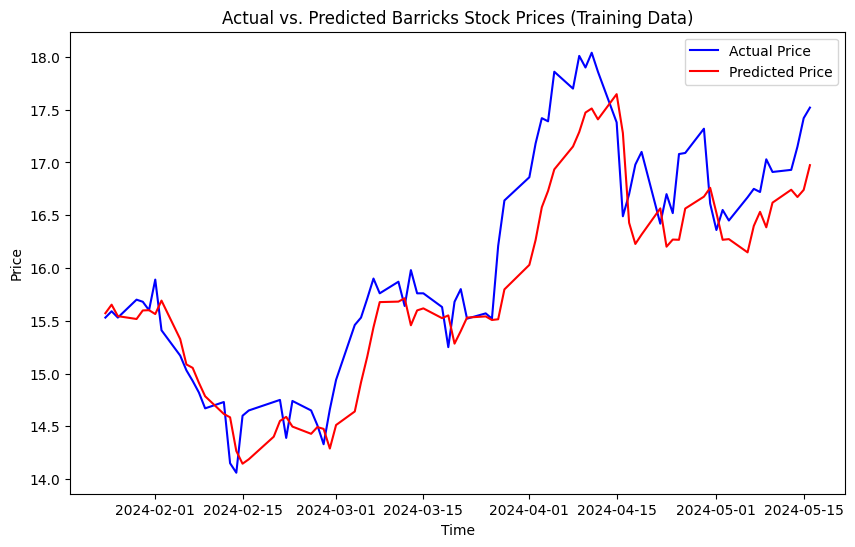

Mean Squared Error of True Data (MSE): 0.1988411271012848
Mean Squared Error of Scaled Data (MSE): 0.012552797443121322


In [ ]:
# Plotting the actual vs. predicted barrick_new stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_new_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_new_RNN_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barricks Stock Prices (Training Data)')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (MSE):", mean_squared_error(y_barrick_new_true, pred_barrick_new_RNN_true))
print("Mean Squared Error of Scaled Data (MSE):", mean_squared_error(y_barrick_new, pred_barrick_new_RNN))

In [ ]:
# Create the predictions
pred_barrick_new_LSTM = model_LSTM_Gold.predict(X_barrick_new)
pred_barrick_new_LSTM = pred_barrick_new_LSTM.reshape(len(pred_barrick_new_LSTM))

y_barrick_new_true = pd.DataFrame(inverse_minmax_scaling(y_barrick_new, min(daily_barrick_new['Price']), max(daily_barrick_new['Price'])))
pred_barrick_new_LSTM_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_new_LSTM, min(daily_barrick_new['Price']), max(daily_barrick_new['Price'])))

pred_barrick_new_LSTM_true.set_index(y_barrick_new_true.index, inplace = True)

3/3 [==============================] - 0s 3ms/step


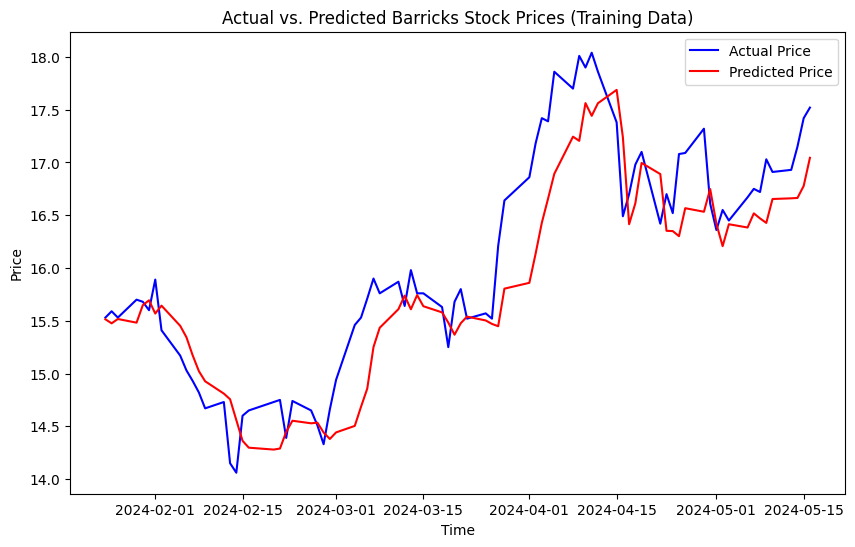

Mean Squared Error of True Data (MSE): 0.21600468451718333
Mean Squared Error of Scaled Data (MSE): 0.013636325821911894


In [ ]:
# Plotting the actual vs. predicted barrick_new stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_barrick_new_true, label='Actual Price', color='blue')
plt.plot(pred_barrick_new_LSTM_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barricks Stock Prices (Training Data)')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (MSE):", mean_squared_error(y_barrick_new_true, pred_barrick_new_LSTM_true))
print("Mean Squared Error of Scaled Data (MSE):", mean_squared_error(y_barrick_new, pred_barrick_new_LSTM))

In [ ]:
# Create the predictions
pred_barrick_new_GRU = model_GRU_Gold.predict(X_barrick_new)
pred_barrick_new_GRU = pred_barrick_new_GRU.reshape(len(pred_barrick_new_GRU))

y_barrick_new_true = pd.DataFrame(inverse_minmax_scaling(y_barrick_new, min(daily_barrick_new['Price']), max(daily_barrick_new['Price'])))
pred_barrick_new_GRU_true = pd.DataFrame(inverse_minmax_scaling(pred_barrick_new_GRU, min(daily_barrick_new['Price']), max(daily_barrick_new['Price'])))

pred_barrick_new_GRU_true.set_index(y_barrick_new_true.index, inplace = True)

3/3 [==============================] - 0s 3ms/step


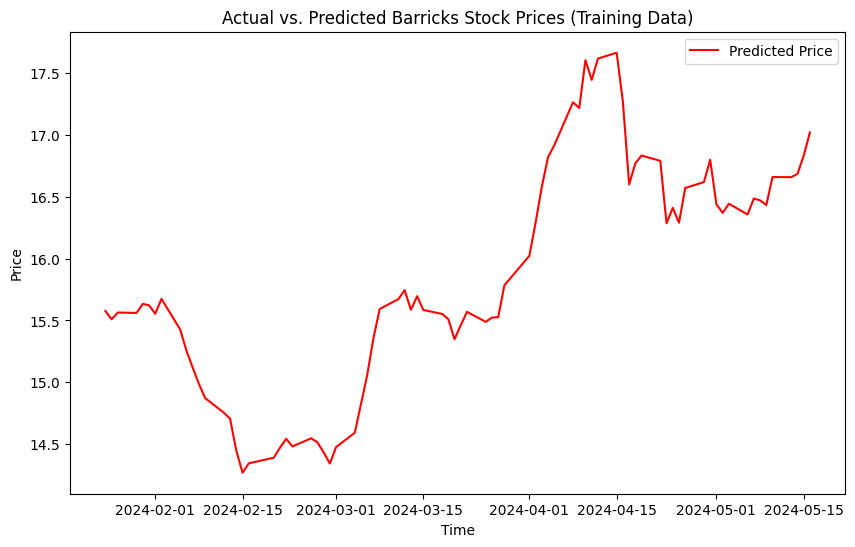

Mean Squared Error of True Data (MSE): 0.1789201575898233
Mean Squared Error of Scaled Data (MSE): 0.011295188271431191


In [ ]:
# Plotting the actual vs. predicted barrick_new stock prices
plt.figure(figsize=(10, 6))
plt.plot(pred_barrick_new_GRU_true, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Barricks Stock Prices (Training Data)')
plt.legend()
plt.show()

print("Mean Squared Error of True Data (MSE):", mean_squared_error(y_barrick_new_true, pred_barrick_new_GRU_true))
print("Mean Squared Error of Scaled Data (MSE):", mean_squared_error(y_barrick_new, pred_barrick_new_GRU))

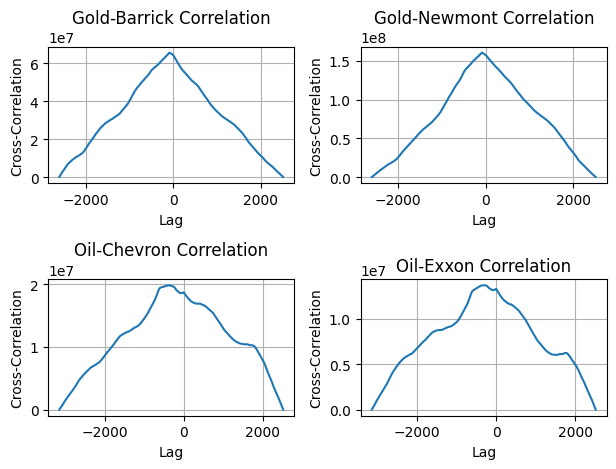

In [ ]:
# Normalize


# Compute correlations
gold_barrick_correlation = correlate(daily_gold['Price'], daily_barrick['Price'], mode='full')
gold_newmont_correlation = correlate(daily_gold['Price'], daily_newmont['Price'], mode='full')
oil_chevron_correlation = correlate(daily_oil['Price'], daily_chevron['Price'], mode='full')
oil_exxon_correlation = correlate(daily_oil['Price'], daily_exxon['Price'], mode='full')

# Compute lags
lags_gold_barrick = np.arange(-len(daily_gold['Price']) + 1, len(daily_barrick['Price']))
lags_gold_newmont = np.arange(-len(daily_gold['Price']) + 1, len(daily_newmont['Price']))
lags_oil_chevron = np.arange(-len(daily_oil['Price']) + 1, len(daily_chevron['Price']))
lags_oil_exxon = np.arange(-len(daily_oil['Price']) + 1, len(daily_exxon['Price']))

# Create subplots
fig, axs = plt.subplots(2, 2)

# Plot each correlation on its respective subplot
axs[0, 0].plot(lags_gold_barrick, gold_barrick_correlation)
axs[0, 0].set_title('Gold-Barrick Correlation')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('Cross-Correlation')
axs[0, 0].grid(True)

axs[0, 1].plot(lags_gold_newmont, gold_newmont_correlation)
axs[0, 1].set_title('Gold-Newmont Correlation')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('Cross-Correlation')
axs[0, 1].grid(True)

axs[1, 0].plot(lags_oil_chevron, oil_chevron_correlation)
axs[1, 0].set_title('Oil-Chevron Correlation')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('Cross-Correlation')
axs[1, 0].grid(True)

axs[1, 1].plot(lags_oil_exxon, oil_exxon_correlation)
axs[1, 1].set_title('Oil-Exxon Correlation')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('Cross-Correlation')
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Modifying Phase

In [ ]:
# RNN 

# Gold

# Same layer amount, less neurons

# Define the model
model_RNN_Gold_revamp_1 = Sequential([
    SimpleRNN(64, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    SimpleRNN(32, activation = 'relu', return_sequences=True),
    SimpleRNN(16, activation = 'relu', return_sequences=True),
    SimpleRNN(8, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_RNN_Gold_revamp_1.compile(optimizer='adam', loss='mse')

# Train the model
model_RNN_Gold_revamp_1.fit(X_train_gold, y_train_gold, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_RNN_Gold_train_revamp_1 = model_RNN_Gold_revamp_1.evaluate(X_train_gold, y_train_gold)
loss_RNN_Gold_test_revamp_1 = model_RNN_Gold_revamp_1.evaluate(X_test_gold, y_test_gold)
print("Train Loss:", loss_RNN_Gold_train_revamp_1)
print("Test Loss:", loss_RNN_Gold_test_revamp_1)

#Predict
pred_gold_train_RNN_revamp_1 = model_RNN_Gold_revamp_1.predict(X_train_gold)
pred_gold_train_RNN_revamp_1 = pred_gold_train_RNN_revamp_1.reshape(len(pred_gold_train_RNN_revamp_1))

pred_gold_test_RNN_revamp_1 = model_RNN_Gold_revamp_1.predict(X_test_gold)
pred_gold_test_RNN_revamp_1 = pred_gold_test_RNN_revamp_1.reshape(len(pred_gold_test_RNN_revamp_1))

Epoch 1/100
52/52 [==============================] - 2s 15ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 2/100
52/52 [==============================] - 0s 7ms/step - loss: 3.7750e-04 - val_loss: 0.0014
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 2.7064e-04 - val_loss: 5.8901e-04
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 2.1784e-04 - val_loss: 5.8468e-04
Epoch 5/100
52/52 [==============================] - 0s 8ms/step - loss: 1.9360e-04 - val_loss: 4.9176e-04
Epoch 6/100
52/52 [==============================] - 0s 7ms/step - loss: 1.8854e-04 - val_loss: 7.7613e-04
Epoch 7/100
52/52 [==============================] - 0s 7ms/step - loss: 1.7613e-04 - val_loss: 4.5694e-04
Epoch 8/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6395e-04 - val_loss: 9.3578e-04
Epoch 9/100
52/52 [==============================] - 0s 8ms/step - loss: 1.4513e-04 - val_loss: 6.5197e-04
Epoch 10/100
52/52 [============================

In [ ]:
pred_gold_test_RNN_revamp_1 = pd.DataFrame(inverse_minmax_scaling(pred_gold_test_RNN_revamp_1, min(daily_gold['Price']), max(daily_gold['Price'])))
pred_gold_train_RNN_revamp_1 = pd.DataFrame(inverse_minmax_scaling(pred_gold_train_RNN_revamp_1, min(daily_gold['Price']), max(daily_gold['Price'])))

pred_gold_train_RNN_revamp_1.set_index(y_train_gold_true.index, inplace = True)
pred_gold_test_RNN_revamp_1.set_index(y_test_gold_true.index, inplace = True)

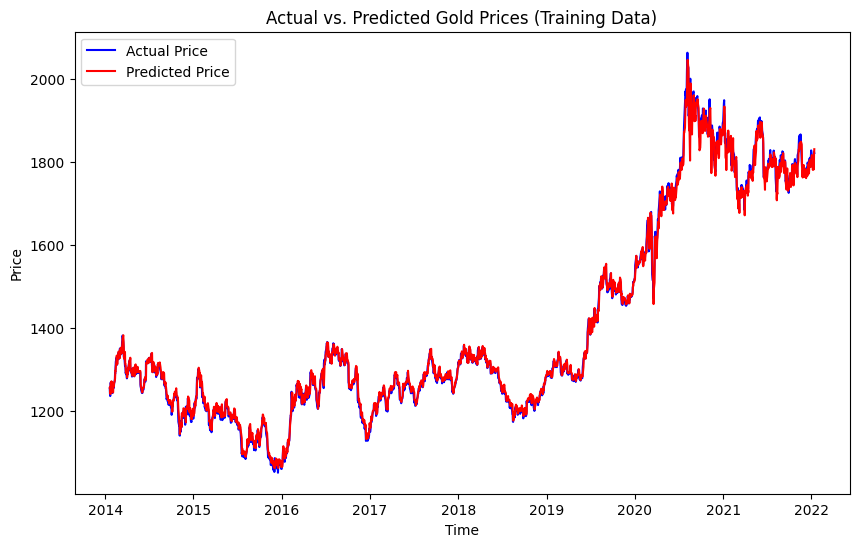

Root Mean Squared Error (RMSE): 231.52286383192916


In [ ]:
# Plotting the actual vs. predicted gold prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_train_RNN_revamp_1, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_gold_true, pred_gold_train_RNN_revamp_1))

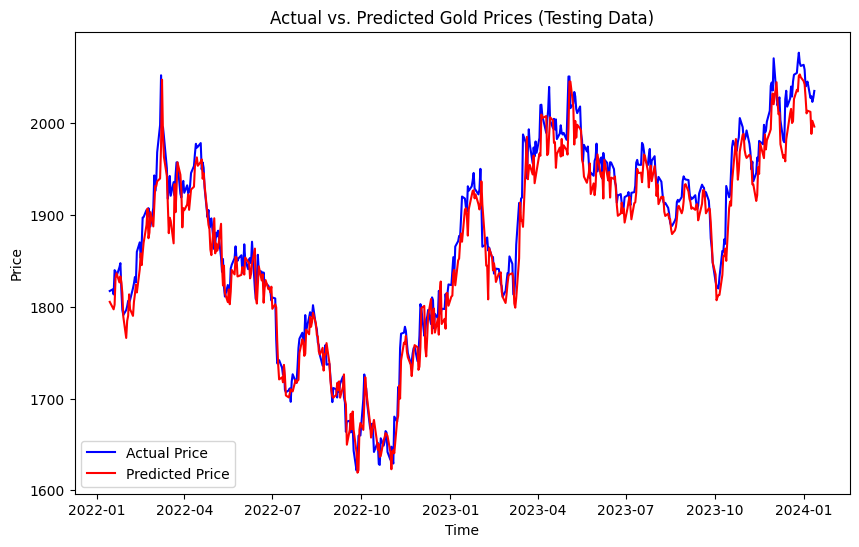

Root Mean Squared Error (RMSE): 541.6430327994968


In [ ]:
# Plotting the actual vs. predicted gold prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_gold_true, label='Actual Price', color='blue')
plt.plot(pred_gold_test_RNN_revamp_1, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Gold Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_gold_true, pred_gold_test_RNN_revamp_1))

In [ ]:
# RNN 

# Oil

# Same layer amount, less neurons

# Define the model
model_RNN_Oil_revamp_1 = Sequential([
    SimpleRNN(64, activation = 'relu', return_sequences=True, input_shape=(window_size, len(features))),
    SimpleRNN(32, activation = 'relu', return_sequences=True),
    SimpleRNN(16, activation = 'relu', return_sequences=True),
    SimpleRNN(8, activation = 'relu'),
    Dense(1)
])

# Compile the model
model_RNN_Oil_revamp_1.compile(optimizer='adam', loss='mse')

# Train the model
model_RNN_Oil_revamp_1.fit(X_train_oil, y_train_oil, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_RNN_Oil_train_revamp_1 = model_RNN_Oil_revamp_1.evaluate(X_train_oil, y_train_oil)
loss_RNN_Oil_test_revamp_1 = model_RNN_Oil_revamp_1.evaluate(X_test_oil, y_test_oil)
print("Train Loss:", loss_RNN_Oil_train_revamp_1)
print("Test Loss:", loss_RNN_Oil_test_revamp_1)

#Predict
pred_oil_train_RNN_revamp_1 = model_RNN_Oil_revamp_1.predict(X_train_oil)
pred_oil_train_RNN_revamp_1 = pred_oil_train_RNN_revamp_1.reshape(len(pred_oil_train_RNN_revamp_1))

pred_oil_test_RNN_revamp_1 = model_RNN_Oil_revamp_1.predict(X_test_oil)
pred_oil_test_RNN_revamp_1 = pred_oil_test_RNN_revamp_1.reshape(len(pred_oil_test_RNN_revamp_1))

Epoch 1/100
63/63 [==============================] - 3s 15ms/step - loss: 0.0638 - val_loss: 6.7232e-04
Epoch 2/100
63/63 [==============================] - 1s 10ms/step - loss: 2.3840e-04 - val_loss: 5.4754e-04
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 1.5662e-04 - val_loss: 5.4554e-04
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 1.5248e-04 - val_loss: 5.5798e-04
Epoch 5/100
63/63 [==============================] - 1s 10ms/step - loss: 1.5357e-04 - val_loss: 5.3967e-04
Epoch 6/100
63/63 [==============================] - 1s 10ms/step - loss: 1.4882e-04 - val_loss: 5.3584e-04
Epoch 7/100
63/63 [==============================] - 1s 10ms/step - loss: 1.4750e-04 - val_loss: 5.2515e-04
Epoch 8/100
63/63 [==============================] - 1s 10ms/step - loss: 1.5064e-04 - val_loss: 5.2679e-04
Epoch 9/100
63/63 [==============================] - 1s 10ms/step - loss: 1.4779e-04 - val_loss: 5.1946e-04
Epoch 10/100
63/63 [=============

In [ ]:
pred_oil_test_RNN_revamp_1 = pd.DataFrame(inverse_minmax_scaling(pred_oil_test_RNN_revamp_1, min(daily_oil['Price']), max(daily_oil['Price'])))
pred_oil_train_RNN_revamp_1 = pd.DataFrame(inverse_minmax_scaling(pred_oil_train_RNN_revamp_1, min(daily_oil['Price']), max(daily_oil['Price'])))

pred_oil_train_RNN_revamp_1.set_index(y_train_oil_true.index, inplace = True)
pred_oil_test_RNN_revamp_1.set_index(y_test_oil_true.index, inplace = True)

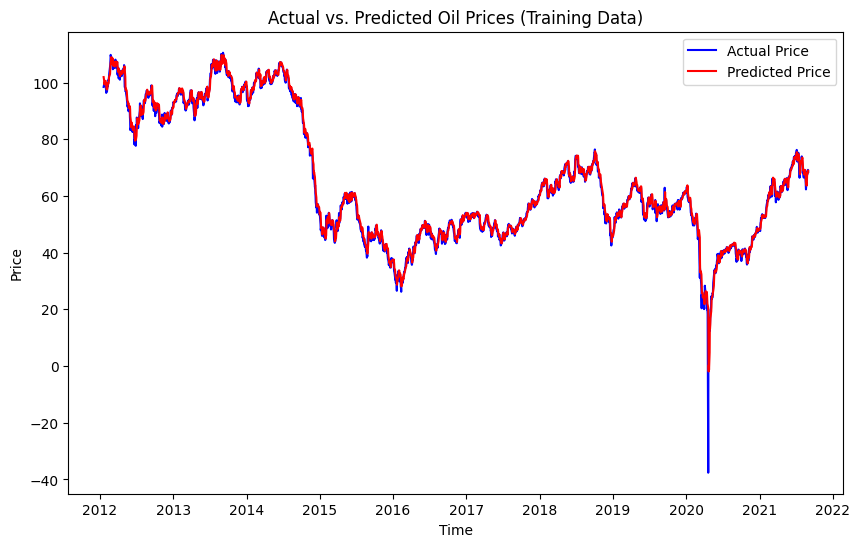

Root Mean Squared Error (RMSE): 4.00420483914446


In [ ]:
# Plotting the actual vs. predicted oil prices for training
plt.figure(figsize=(10, 6))
plt.plot(y_train_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_train_RNN_revamp_1, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Training Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_train_oil_true, pred_oil_train_RNN_revamp_1))

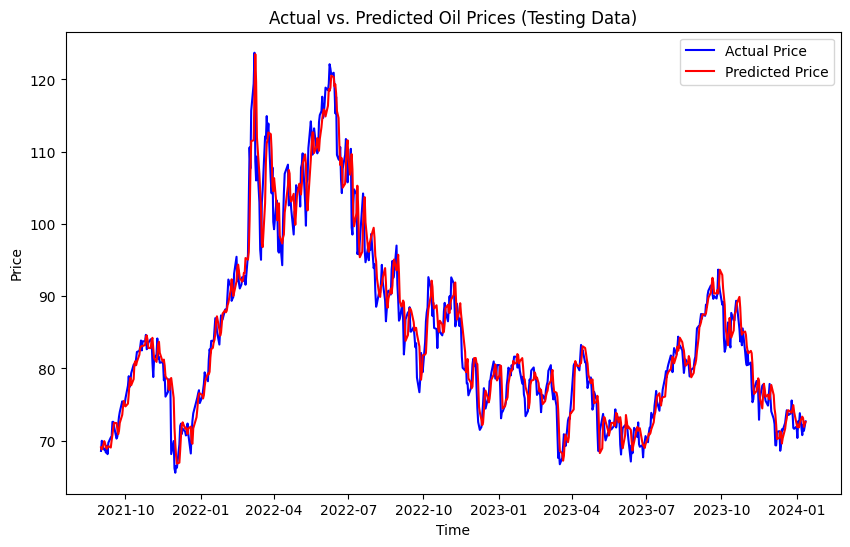

Root Mean Squared Error (RMSE): 8.373712003541904


In [ ]:
# Plotting the actual vs. predicted oil prices for testing
plt.figure(figsize=(10, 6))
plt.plot(y_test_oil_true, label='Actual Price', color='blue')
plt.plot(pred_oil_test_RNN_revamp_1, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Oil Prices (Testing Data)')
plt.legend()
plt.show()

print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test_oil_true, pred_oil_test_RNN_revamp_1))

In [ ]:
# Gold RNN Weights and Biases
weights_and_biases_RNN_gold = model_RNN_Gold_mini.get_weights()

for layer in model_RNN_Gold_mini.layers:
    print(f"Layer {layer.name}:")
    weights = layer.get_weights()
    for i, weight in enumerate(weights):
        print(f"  Weight {i}: {weight}")

Layer simple_rnn_4:
  Weight 0: [[ 0.57241434  0.5707887   0.43635768]
 [-0.11927641 -0.6055566   1.1102309 ]
 [ 0.775113    0.39019138 -0.42869887]
 [ 0.5844466   0.66043407 -0.24105771]]
  Weight 1: [[ 0.51458436 -0.68914145 -0.24063341]
 [-0.19654849  0.34755373 -0.7601009 ]
 [-0.9508444  -0.6162934  -0.21138677]]
  Weight 2: [-0.19270697  0.09682255  0.04734078]
Layer simple_rnn_5:
  Weight 0: [[-0.24830925  0.06137959]
 [-0.9686768   0.8348581 ]
 [-0.24330258 -1.0618478 ]]
  Weight 1: [[ 0.6533439   0.75706124]
 [-0.75706124  0.5992652 ]]
  Weight 2: [ 0.         -0.04976025]
Layer dense_1:
  Weight 0: [[ 0.61141026]
 [-0.4575549 ]]
  Weight 1: [0.48927027]


In [ ]:
# Oil RNN Weights and Biases
weights_and_biases_RNN_oil = model_RNN_Oil_mini.get_weights()

for layer in model_RNN_Oil_mini.layers:
    print(f"Layer {layer.name}:")
    weights = layer.get_weights()
    for i, weight in enumerate(weights):
        print(f"  Weight {i}: {weight}")

Layer simple_rnn_10:
  Weight 0: [[-0.44388124  0.797928    0.55916363]
 [ 0.07577112 -0.5724575  -0.6276217 ]
 [ 0.970923   -0.7775824  -0.1334143 ]
 [-0.19681369 -0.35563636  0.31823176]]
  Weight 1: [[ 0.04587556 -0.8475645   0.30972102]
 [ 0.85621685 -0.4172926  -0.30456463]
 [-0.45318776 -0.32787365 -0.8317936 ]]
  Weight 2: [-0.03888585  0.          0.01021454]
Layer simple_rnn_11:
  Weight 0: [[-0.20053431 -0.47840807]
 [-0.90590614  0.69363236]
 [ 0.23940547  0.89129406]]
  Weight 1: [[ 0.8299425   0.5129191 ]
 [-0.48222804  0.940427  ]]
  Weight 2: [0.01865044 0.00346284]
Layer dense_3:
  Weight 0: [[-1.1052591 ]
 [-0.53876746]]
  Weight 1: [0.849283]


In [ ]:
# Gold GRU Weights and Biases
weights_and_biases_GRU_gold = model_GRU_Gold_mini.get_weights()

for layer in model_GRU_Gold_mini.layers:
    print(f"Layer {layer.name}:")
    weights = layer.get_weights()
    for i, weight in enumerate(weights):
        print(f"  Weight {i}: {weight}")

Layer gru_4:
  Weight 0: [[-0.32477346 -0.40413052  0.36751914  0.10710541  0.06526057  0.3021118
  -0.35515276  0.22622228 -0.5601158 ]
 [ 0.03352977 -0.34246606 -0.36499214 -0.25188768  0.8154616   0.19349465
   0.729241    0.2893533  -0.6718902 ]
 [-0.37019712 -0.08269005 -0.08176886 -0.42671508 -0.34330747 -0.23504774
   0.39097336  0.18225326 -0.5312145 ]
 [-0.55394006  0.16001573 -0.5173019   1.0823594   1.011177    0.92373955
   0.0397414  -0.19241308  0.25637484]]
  Weight 1: [[ 0.324374    0.6846396   0.02301573  0.2426125   0.09973107  0.02623721
   0.65704197  0.4476206   0.259306  ]
 [-0.03921367  0.6603136   0.23195574  0.2785154  -0.01879892  0.31123507
  -0.11405078 -0.67928416  0.7383428 ]
 [-0.14929946 -0.13239038  0.28916556  0.40939233  0.35456544 -0.13819066
  -0.01292812 -0.16517815 -0.9140417 ]]
  Weight 2: [[-0.23073871  0.33744287 -0.11239156 -0.00964386  0.01922943  0.31778455
   0.00131967 -0.02554208 -0.02890994]
 [-0.23073871  0.33744287 -0.11239156 -0.00964

In [ ]:
# Oil GRU Weights and Biases
weights_and_biases_GRU_oil = model_GRU_Oil_mini.get_weights()

for layer in model_GRU_Oil_mini.layers:
    print(f"Layer {layer.name}:")
    weights = layer.get_weights()
    for i, weight in enumerate(weights):
        print(f"  Weight {i}: {weight}")

Layer gru_10:
  Weight 0: [[ 0.2843059  -0.70099497  0.0278506   0.11558157 -0.39333048 -0.08683071
  -0.5072268   0.00912096 -0.20802632]
 [-0.14501585 -0.25723982  0.41343048  0.77125365 -0.25990963 -0.6300324
   0.11607079 -0.02993173 -0.65260774]
 [-0.64616686 -0.00078405 -0.38888732 -0.08734801 -0.16028443  0.17340533
   0.05204669  0.6647571   0.12919545]
 [-0.59478176 -0.2204494  -0.7773499   0.6971826  -0.51153857  0.20902067
   0.36419463  0.21201429  0.52868915]]
  Weight 1: [[-0.09820024 -0.9308781  -0.50186664  0.14015302  0.5618587  -0.44450495
   0.19461459 -0.10641275  0.04683765]
 [ 0.23076029 -0.00647275  0.47827798 -0.22411902  0.18622313 -0.05289062
   0.34686324 -0.02222954  0.30646056]
 [ 0.3138994  -0.3883446  -0.41844806 -0.5020175  -0.23221497  0.05931713
  -0.18809123 -0.86110765 -0.12974006]]
  Weight 2: [[-0.05317213 -0.08883698 -0.12487464  0.0723496   0.02829241  0.0712353
   0.06458326  0.05765288  0.0318803 ]
 [-0.05317213 -0.08883698 -0.12487464  0.07234

In [ ]:
# Gold LSTM Weights and Biases
weights_and_biases_LSTM_gold = model_LSTM_Gold_mini.get_weights()

for layer in model_LSTM_Gold_mini.layers:
    print(f"Layer {layer.name}:")
    weights = layer.get_weights()
    for i, weight in enumerate(weights):
        print(f"  Weight {i}: {weight}")

Layer lstm_4:
  Weight 0: [[ 2.70797074e-01  1.73846051e-01 -1.29530020e-02 -2.46497959e-01
  -1.03860795e-01  2.29712114e-01 -5.21709502e-01  6.32586479e-01
  -2.42238849e-01 -2.99254537e-01  3.17497551e-01  4.97741916e-04]
 [-2.70390451e-01  6.85513467e-02 -3.51113200e-01  1.91791117e-01
   1.12768255e-01 -4.21010971e-01 -4.98422354e-01  3.46968412e-01
   4.65043157e-01  4.26223814e-01 -2.56958514e-01 -3.49699616e-01]
 [ 3.77861321e-01 -2.86967427e-01 -2.28428897e-02  1.73557937e-01
   6.68021619e-01  5.62801063e-02 -2.58359522e-01  1.28825754e-01
   5.91968656e-01  5.43000996e-01  3.57052177e-01  4.61496115e-01]
 [-4.35774207e-01  3.95568192e-01  2.18827933e-01  4.21524346e-01
   6.35220230e-01  3.22974533e-01 -2.37995028e-01  2.21945181e-01
   3.47122431e-01 -1.13168269e-01  7.23264456e-01 -6.75948143e-01]]
  Weight 1: [[ 0.44023657  0.03390197 -0.28050017 -0.0233858   0.11330712  0.19618148
   0.636252    0.19508675  0.1792378   0.14002313  0.19259532  0.3778737 ]
 [ 0.2598671   0

In [ ]:
# Oil LSTM Weights and Biases
weights_and_biases_LSTM_oil = model_LSTM_Oil_mini.get_weights()

for layer in model_LSTM_Oil_mini.layers:
    print(f"Layer {layer.name}:")
    weights = layer.get_weights()
    for i, weight in enumerate(weights):
        print(f"  Weight {i}: {weight}")

Layer lstm_10:
  Weight 0: [[ 0.19976872  0.01330638 -0.505928    0.5983266   0.14434779  0.53312093
  -0.4608519  -0.33109283 -0.51984215  0.19726878 -0.5011247  -0.6085017 ]
 [ 0.45647496 -0.26462018 -0.13783398  0.14231169 -0.5796116  -0.3277935
  -0.3828839   0.5123976  -0.36811632 -0.58514607  0.15366966  0.5462163 ]
 [-0.15015936 -0.06798798  0.07845902 -0.4349607   0.15290684  0.59278005
   0.45361787 -0.12471855 -0.35955456 -0.13269591 -0.469241   -0.49794316]
 [ 0.48384386 -0.49021915  0.5236936  -0.22173649  0.5014525  -0.17770886
   0.37251562 -0.02932781  0.21889865 -0.08082598 -0.35540813  0.0676744 ]]
  Weight 1: [[-0.27759254 -0.15971579  0.24422455 -0.09481209  0.3132998   0.02958697
   0.16130929  0.50637907  0.23350123 -0.4264917  -0.23708259  0.39331883]
 [-0.12994993 -0.11302979  0.28815824  0.10820347 -0.48507935 -0.28412724
  -0.24678406 -0.37620306  0.1886219  -0.5080086  -0.23147753 -0.09949853]
 [-0.29057086 -0.40727532 -0.00324348  0.07004802  0.3540488  -0.20

In [ ]:
X_gold[0]

array([[0.19164993, 0.18036693, 0.19366639, 0.59259259],
       [0.19636903, 0.1805531 , 0.1918128 , 0.48053181],
       [0.18854937, 0.17125411, 0.18461418, 0.51851852],
       [0.18502954, 0.1711331 , 0.1866345 , 0.55080722],
       [0.18604356, 0.18046002, 0.18810561, 0.6305793 ]])

In [ ]:
y_gold[0][0]

/tmp/ipykernel_85/1061818878.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_gold[0][0]


0.1976181651483524

In [ ]:
# Example input
x0 = np.array([[0.19636903, 0.1805531 , 0.1918128 , 0.48053181],
            [0.18854937, 0.17125411, 0.18461418, 0.51851852],
            [0.18502954, 0.1711331 , 0.1866345 , 0.55080722],
            [0.18604356, 0.18046002, 0.18810561, 0.6305793 ],
            [0.19723679, 0.18578436, 0.20112   , 0.54795821]])

# Weights and biases for simple_rnn_4
W_input_0 = np.array([[ 0.57241434,  0.5707887 ,  0.43635768],
                      [-0.11927641, -0.6055566 ,  1.1102309 ],
                      [ 0.775113  ,  0.39019138, -0.42869887],
                      [ 0.5844466 ,  0.66043407, -0.24105771]])

W_recurrent_0 = np.array([[ 0.51458436, -0.68914145, -0.24063341],
                          [-0.19654849,  0.34755373, -0.7601009 ],
                          [-0.9508444 , -0.6162934 , -0.21138677]])

bias_0 = np.array([-0.19270697,  0.09682255,  0.04734078])

# Weights and biases for simple_rnn_5
W_input_1 = np.array([[-0.24830925,  0.06137959],
                      [-0.9686768 ,  0.8348581 ],
                      [-0.24330258, -1.0618478 ]])

W_recurrent_1 = np.array([[ 0.6533439 ,  0.75706124],
                          [-0.75706124,  0.5992652 ]])

bias_1 = np.array([ 0.        , -0.04976025])

# Activation function (ReLU)
def relu(x):
    return np.maximum(0, x)

# Initial hidden state for simple_rnn_4
h_t = np.zeros((3,))

# Process each time step for the first SimpleRNN layer
input_to_rnn_5 = []

for t in range(x0.shape[0]):
    x_t = x0[t]
    h_t = relu(np.dot(x_t, W_input_0) + np.dot(h_t, W_recurrent_0) + bias_0)
    input_to_rnn_5.append(h_t)

input_to_rnn_5 = np.array(input_to_rnn_5)

# Initial hidden state for the second SimpleRNN layer
h_t1 = np.zeros((2,))

# Process each time step for the second SimpleRNN layer
for t in range(input_to_rnn_5.shape[0]):
    x_t1 = input_to_rnn_5[t]
    h_t1 = relu(np.dot(x_t1, W_input_1) + np.dot(h_t1, W_recurrent_1) + bias_1)
    print(f"Hidden state at time {t} for simple_rnn_5: {h_t1}")

# Final hidden state for the dense layer input
final_hidden_state = h_t1

# Weights and biases for dense_1 layer
W_dense = np.array([[ 0.61141026], [-0.4575549]])
bias_dense = np.array([0.48927027])

# Compute the dense layer output
dense_output = np.dot(final_hidden_state, W_dense) + bias_dense
print(f"Dense layer output: {dense_output}")

Hidden state at time 0 for simple_rnn_5: [0.         0.23712295]
Hidden state at time 1 for simple_rnn_5: [0.         0.42440739]
Hidden state at time 2 for simple_rnn_5: [0.         0.62391564]
Hidden state at time 3 for simple_rnn_5: [0.         0.73252627]
Hidden state at time 4 for simple_rnn_5: [0.         0.69425885]
Dense layer output: [0.17160873]


In [ ]:
model_RNN_Gold_mini.predict(X_train_gold)

65/65 [==============================] - 0s 2ms/step


array([[0.1726866 ],
       [0.17160875],
       [0.21609509],
       ...,
       [0.48927027],
       [0.48927027],
       [0.48927027]], dtype=float32)

In [ ]:
import numpy as np

# Input sequence (x0)
x0 = np.array([[0.19164993, 0.18036693, 0.19366639, 0.59259259],
               [0.19636903, 0.1805531 , 0.1918128 , 0.48053181],
               [0.18854937, 0.17125411, 0.18461418, 0.51851852],
               [0.18502954, 0.1711331 , 0.1866345 , 0.55080722],
               [0.18604356, 0.18046002, 0.18810561, 0.6305793 ]])

# Extracted weights and biases for gru_4
W_z_4, W_r_4, W_h_4 = np.split(np.array([[-0.32477346, -0.40413052,  0.36751914,  0.10710541,  0.06526057,  0.3021118,
                                    -0.35515276,  0.22622228, -0.5601158],
                                    [0.03352977, -0.34246606, -0.36499214, -0.25188768,  0.8154616,  0.19349465,
                                     0.729241,  0.2893533, -0.6718902],
                                    [-0.37019712, -0.08269005, -0.08176886, -0.42671508, -0.34330747, -0.23504774,
                                     0.39097336,  0.18225326, -0.5312145],
                                    [-0.55394006, 0.16001573, -0.5173019, 1.0823594, 1.011177, 0.92373955,
                                     0.0397414, -0.19241308, 0.25637484]]), 3, axis=1)

U_z_4, U_r_4, U_h_4 = np.split(np.array([[0.324374, 0.6846396, 0.02301573, 0.2426125, 0.09973107, 0.02623721,
                                    0.65704197, 0.4476206, 0.259306],
                                   [-0.03921367, 0.6603136, 0.23195574, 0.2785154, -0.01879892, 0.31123507,
                                    -0.11405078, -0.67928416, 0.7383428],
                                   [-0.14929946, -0.13239038, 0.28916556, 0.40939233, 0.35456544, -0.13819066,
                                    -0.01292812, -0.16517815, -0.9140417]]), 3, axis=1)

b_z_4, b_r_4, b_h_4 = np.split(np.array([[-0.23073871, 0.33744287, -0.11239156, -0.00964386, 0.01922943, 0.31778455,
                                    0.00131967, -0.02554208, -0.02890994],
                                   [-0.23073871, 0.33744287, -0.11239156, -0.00964386, 0.01922943, 0.31778455,
                                    0.04720319, 0.03504283, -0.05447516]]), 3, axis=1)

# Extracted weights and biases for gru_5
W_z_5, W_r_5, W_h_5 = np.split(np.array([[-0.11565776, -0.16771916, -0.05069848, -0.10107652, 0.2031672, 0.38842547],
                                        [0.3314597, -0.41802305, -0.95755875, -0.21280599, -0.1284951, 0.51880085],
                                        [-0.7456997, -0.53482807, -0.04970732, 0.29547977, -0.6176726, 0.16490354]]), 3, axis=1)

U_z_5, U_r_5, U_h_5 = np.split(np.array([[0.66113037, -0.62095624, -0.23689945, 0.41017267, 0.08666687, -0.05202212],
                                         [0.12754706, -0.20501631, 0.24104188, -0.40521264, 0.08408531, -0.65792567]]), 3, axis=1)

b_z_5, b_r_5, b_h_5 = np.split(np.array([[-0.14906427, -0.19360389, -0.00987003, 0.08671819, 0.00259631, -0.01431703],
                                        [-0.14906427, -0.19360389, -0.00987003, 0.08671819, 0.00540897, -0.01361621]]), 3, axis=1)

# Extracted weights and biases for dense_5
W_dense = np.array([[1.4133223], [1.3623364]])
b_dense = np.array([-0.01491678])

# GRU cell feedforward function
def gru_cell_forward(x, h_prev, W_z, W_r, W_h, U_z, U_r, U_h, b_z, b_r, b_h):
    # Update gate
    z = sigmoid(np.dot(x, W_z) + np.dot(h_prev, U_z) + b_z)
    
    # Reset gate
    r = sigmoid(np.dot(x, W_r) + np.dot(h_prev, U_r) + b_r)
    
    # Candidate hidden state
    h_tilde = np.tanh(np.dot(x, W_h) + np.dot(r * h_prev, U_h) + b_h)
    
    # Current hidden state
    h = z * h_prev + (1 - z) * h_tilde
    
    return h

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Initial hidden state for gru_4
h_prev_4 = np.zeros((1, 3))  # Size of the hidden state for gru_4

# Process each time step for gru_4
for t in range(x0.shape[0]):
    x_t = x0[t].reshape(1, -1)
    h_prev_4 = gru_cell_forward(x_t, h_prev_4, W_z_4, W_r_4, W_h_4, U_z_4, U_r_4, U_h_4, b_z_4, b_r_4, b_h_4)

# The output of gru_4 becomes the input to gru_5
gru_5_input = h_prev_4

# Initial hidden state for gru_5
h_prev_5 = np.zeros((1, 2))  # Size of the hidden state for gru_5

# Process the input for gru_5 (no sequence, just the final output of gru_4)
h_prev_5 = gru_cell_forward(gru_5_input, h_prev_5, W_z_5, W_r_5, W_h_5, U_z_5, U_r_5, U_h_5, b_z_5, b_r_5, b_h_5)

# The output of gru_5 goes into the dense layer
dense_input = h_prev_5

# Forward pass through the dense layer
output = np.dot(dense_input, W_dense) + b_dense

print("Final output of the model:", output)


Final output of the model: [[0.12042789]
 [0.16383203]]


In [ ]:
x0[1]

array([0.19636903, 0.1805531 , 0.1918128 , 0.48053181])

In [ ]:
x0[1].reshape(1, -1)

array([[0.19636903, 0.1805531 , 0.1918128 , 0.48053181]])

In [ ]:
import numpy as np

# Input example x0
x0 = np.array([[0.19164993, 0.18036693, 0.19366639, 0.59259259],
               [0.19636903, 0.1805531, 0.1918128, 0.48053181],
               [0.18854937, 0.17125411, 0.18461418, 0.51851852],
               [0.18502954, 0.1711331, 0.1866345, 0.55080722],
               [0.18604356, 0.18046002, 0.18810561, 0.6305793]])

# Weights and biases for the first GRU layer (gru_4)
W1 = np.array([[-0.32477346, -0.40413052,  0.36751914,  0.10710541,  0.06526057,  0.3021118, -0.35515276,  0.22622228, -0.5601158 ],
               [ 0.03352977, -0.34246606, -0.36499214, -0.25188768,  0.8154616,  0.19349465, 0.729241,  0.2893533, -0.6718902 ],
               [-0.37019712, -0.08269005, -0.08176886, -0.42671508, -0.34330747, -0.23504774, 0.39097336,  0.18225326, -0.5312145 ],
               [-0.55394006,  0.16001573, -0.5173019,  1.0823594,  1.011177,  0.92373955, 0.0397414, -0.19241308,  0.25637484]])
U1 = np.array([[ 0.324374,  0.6846396,  0.02301573,  0.2426125,  0.09973107,  0.02623721, 0.65704197,  0.4476206,  0.259306  ],
               [-0.03921367,  0.6603136,  0.23195574,  0.2785154, -0.01879892,  0.31123507, -0.11405078, -0.67928416,  0.7383428 ],
               [-0.14929946, -0.13239038,  0.28916556,  0.40939233,  0.35456544, -0.13819066, -0.01292812, -0.16517815, -0.9140417 ]])
b1 = np.array([[-0.23073871,  0.33744287, -0.11239156, -0.00964386,  0.01922943,  0.31778455,  0.00131967, -0.02554208, -0.02890994],
               [-0.23073871,  0.33744287, -0.11239156, -0.00964386,  0.01922943,  0.31778455,  0.04720319,  0.03504283, -0.05447516]])

# Weights and biases for the second GRU layer (gru_5)
W2 = np.array([[-0.11565776, -0.16771916, -0.05069848, -0.10107652,  0.2031672,  0.38842547],
               [ 0.3314597, -0.41802305, -0.95755875, -0.21280599, -0.1284951,  0.51880085],
               [-0.7456997, -0.53482807, -0.04970732,  0.29547977, -0.6176726,  0.16490354]])
U2 = np.array([[ 0.66113037, -0.62095624, -0.23689945,  0.41017267,  0.08666687, -0.05202212],
               [ 0.12754706, -0.20501631,  0.24104188, -0.40521264,  0.08408531, -0.65792567]])
b2 = np.array([[-0.14906427, -0.19360389, -0.00987003,  0.08671819,  0.00259631, -0.01431703],
               [-0.14906427, -0.19360389, -0.00987003,  0.08671819,  0.00540897, -0.01361621]])

# Weights and biases for the dense layer (dense_5)
W_dense = np.array([[1.4133223], [1.3623364]])
b_dense = np.array([-0.01491678])

# Function for sigmoid activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function for tanh activation
def tanh(x):
    return np.tanh(x)

# Initial hidden state for first GRU layer
h_prev1 = np.zeros(W1.shape[1] // 3)

# Process the input through the first GRU layer
h1_output = []
for t in range(x0.shape[0]):
    x_t = x0[t]

    # Update gate
    z_t = sigmoid(np.dot(x_t, W1[:, :3]) + np.dot(h_prev1, U1[:, :3]) + b1[:, :3])
    # Reset gate
    r_t = sigmoid(np.dot(x_t, W1[:, 3:6]) + np.dot(h_prev1, U1[:, 3:6]) + b1[:, 3:6])
    # Candidate hidden state
    h_tilde_t = tanh(np.dot(x_t, W1[:, 6:9]) + np.dot(r_t * h_prev1, U1[:, 6:9]) + b1[:, 6:9])
    # Final hidden state
    h_t = (1 - z_t) * h_prev1 + z_t * h_tilde_t
    
    h_prev1 = h_t
    h1_output.append(h_t)

h1_output = np.array(h1_output)

# Initial hidden state for second GRU layer
h_prev2 = np.zeros(W2.shape[1] // 3)

# Process the output of the first GRU layer through the second GRU layer
for t in range(h1_output.shape[0]):
    h1_t = h1_output[t]

    # Update gate
    z_t2 = sigmoid(np.dot(h1_t, W2[:, :2]) + np.dot(h_prev2, U2[:, :2]) + b2[:, :2])
    # Reset gate
    r_t2 = sigmoid(np.dot(h1_t, W2[:, 2:4]) + np.dot(h_prev2, U2[:, 2:4]) + b2[:, 2:4])
    # Candidate hidden state
    h_tilde_t2 = tanh(np.dot(h1_t, W2[:, 4:6]) + np.dot(r_t2 * h_prev2, U2[:, 4:6]) + b2[:, 4:6])
    # Final hidden state
    h_t2 = (1 - z_t2) * h_prev2 + z_t2 * h_tilde_t2
    
    h_prev2 = h_t2

# Process the output of the second GRU layer through the dense layer
output = np.dot(h_prev2, W_dense) + b_dense

print("Final output:", output)


Final output: [[0.16508377]
 [0.21626961]]


In [ ]:
X_gold[0]

array([[0.19164993, 0.18036693, 0.19366639, 0.59259259],
       [0.19636903, 0.1805531 , 0.1918128 , 0.48053181],
       [0.18854937, 0.17125411, 0.18461418, 0.51851852],
       [0.18502954, 0.1711331 , 0.1866345 , 0.55080722],
       [0.18604356, 0.18046002, 0.18810561, 0.6305793 ]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=37cc49da-a460-4de1-b51b-4428efcf8114' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>